# Importing packages

['/Users/amirhsi_mini/research_data/SumRuleCyl-allInOne/N2000D30.0ac6.0-whole-equilProps.csv', '/Users/amirhsi_mini/research_data/SumRuleCyl-allInOne/N2000D30.0ac4.0-bug-chainSize.parquet.brotli', '/Users/amirhsi_mini/research_data/SumRuleCyl-allInOne/N500D10.0ac1.0-whole-equilProps.csv', '/Users/amirhsi_mini/research_data/SumRuleCyl-allInOne/N2000D60.0ac4.0-whole-equilProps.csv', '/Users/amirhsi_mini/research_data/SumRuleCyl-allInOne/N1000D15.0ac2.0-bug-chainSize.parquet.brotli', '/Users/amirhsi_mini/research_data/SumRuleCyl-allInOne/N1000D15.0ac2.0-bug-chainSize-acf.parquet.brotli', '/Users/amirhsi_mini/research_data/SumRuleCyl-allInOne/N2000D25.0ac2.0-bug-chainSize-acf.parquet.brotli', '/Users/amirhsi_mini/research_data/SumRuleCyl-allInOne/N2000D25.0ac4.0-bug-chainSize-acf.parquet.brotli', '/Users/amirhsi_mini/research_data/SumRuleCyl-allInOne/N2000D20.0ac2.0-bug-chainSize.parquet.brotli', '/Users/amirhsi_mini/research_data/SumRuleCyl-allInOne/N500D10.0ac0.6-bug-chainSize-acf.parque

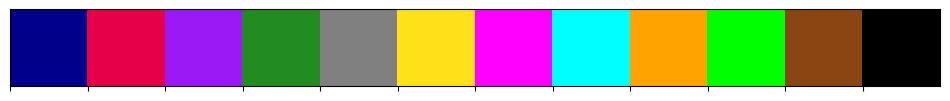

In [1]:
# Importing necessary packages:

from glob import glob
import numpy as np
import pandas as pd

from cmcrameri import cm as crameri

import warnings
warnings.filterwarnings("ignore")
import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from polyphys.visualize import plotter
from polyphys.visualize.plotter import PROJECT_DETAILS as PD
from polyphys.visualize.plotter import TITLE_STYLES as TS
from polyphys.visualize.plotter import ATTRIBUTE_LABELS as AL
from polyphys.visualize.plotter import AMIRHSI_COLORS as AC
from polyphys.visualize.plotter import DUTCH_FEILD_COLORS as DF_colors
from polyphys.visualize.plotter import SIZE_MEASURES_LABELS as SML
from polyphys.visualize.plotter import PAUL_TOL_MUTED as PTM
from polyphys.api import normalize_data

from polyphys.visualize import tuner
from polyphys.manage.parser import SumRuleCyl
from polyphys.manage import organizer
from polyphys.analyze import measurer
from polyphys.manage import utilizer

import imageio
from matplotlib.image import NonUniformImage
from matplotlib.patches import Circle, Rectangle
from matplotlib import cm

# Project details
project = 'SumRuleCyl'

# loading databases:
#allInOne_db = '../../Datasets/'+project+'-allInOne/' # relative
allInOne_db = '/Users/amirhsi_mini/research_data/'+project+'-allInOne/' # relative

space_dbs = glob(allInOne_db + PD[project]['space_pat'])
print(space_dbs)
sns.palplot(AC)

#flar_cmap = mpl.colors.ListedColormap(sns.cm._flare_lut)
#flare_cmap_cut = tuner.truncated_colormap(flar_cmap,  min_value=.1, max_value=1, ncolors=1000)
#mpl.cm.register_cmap("flare_cmap_cut", flare_cmap_cut)


# Confinement rate ($L/D$) and finite-size effects ($Z/L$)

In [ ]:
sumrule_db = '../../Datasets/SumRuleCyl-allInOne/*equilProps-whole.csv'
sumrule_db = glob(sumrule_db)
print(sumrule_db)
equil = pd.read_csv(sumrule_db[0])
print(equil.columns)

In [ ]:
cols = ['n_frames','nmon','dcyl','dcrowd','lcyl','phi_c_bulk_round']
n_equilibrate = 1000000
dt_equilibrate = 0.02
n_dump = 2000
dt = 0.005
damp_melt = 43 # in inverse tau
mean_round = lambda x: np.round(np.mean(x),3)
flory_exponent = 0.588
pre_factor = 1.18 # free space size prefactor
a_const = 1.42 # prefactor for 1D size
x_const = 0.82 # prefactor for blob vs chain size

table_1 = equil.groupby(cols)[cols+['fsdMon-mean']].agg({'fsdMon-mean': mean_round})
table_1.reset_index(inplace=True)
table_1['lcyl/fsdMon'] = np.round(table_1['lcyl'] / table_1['fsdMon-mean'],3)
table_1['dt_equilibrate'] = dt_equilibrate
table_1['step_equilibrate'] = n_equilibrate
table_1['t_equilibrate'] = n_equilibrate * dt_equilibrate
table_1['dt_sampling'] = dt
table_1['step_sampling'] = n_dump * table_1['n_frames']
table_1['t_sampling'] = n_dump * dt * table_1['n_frames']
table_1['t_total'] = table_1['t_sampling'] + table_1['t_equilibrate']
table_1['t_rouse_free'] = pre_factor*table_1['nmon']**(1+2*flory_exponent)*damp_melt/3/np.pi**2
table_1['step_rouse_free'] = table_1['t_rouse_free']/dt
table_1['t_rouse_cylinder'] = (table_1['nmon']**(1.75)
                               *table_1['dcyl']**0.7)
table_1['step_rouse_cylinder'] = table_1['t_rouse_cylinder'] / dt
sort_cols = cols + ['lcyl/fsdMon']
table_1.sort_values(by=sort_cols,inplace=True)
table_1.to_csv(project+'size_lcyl_rouse_time.csv',index=False)

In [ ]:
pre_factor*2000**(1+2*flory_exponent)*damp_melt/3/np.pi**2/100000

In [ ]:
cols = ['nmon','dcyl','dcrowd']
mean_round = lambda x: np.round(np.mean(x),3)
table_2 = equil.groupby(cols)[['phi_c_bulk_round']].count()
table_2.reset_index(inplace=True)
#table_2['lcyl/fsdMon'] = np.round(table_1['lcyl'] / table_1['fsdMon-mean'],3)
#sort_cols = cols + ['lcyl/fsdMon']
table_2.sort_values(by=cols,inplace=True)
table_2.to_csv('table_2.csv',index=False)

# Analyze Log file

In [ ]:
# Load datasets
df = pd.read_csv('../../Datasets/SumRuleCyl-allInOne/allInOne-SumRuleCyl-runStat-shorten.csv')
wall_time_df = pd.read_csv('../../Datasets/SumRuleCyl-allInOne/allInOne-SumRuleCyl-wallTimeStat.csv')

# Grouping and aggregation for the first dataset
new_grouped_df = df.groupby('whole').agg({
    'n_cores': 'last',
    'n_atoms': 'last',
    'space': 'last',
    'ensemble_long': 'last',
    'loop_idx': 'count',
    'loop_timesteps': 'sum',
    'loop_time': 'sum'
}).reset_index()

# Convert loop_time to hours and compute timestep_per_second
new_grouped_df['loop_time_hr'] = new_grouped_df['loop_time'] / 3600
new_grouped_df['timestep_per_second'] = new_grouped_df['loop_timesteps'] / new_grouped_df['loop_time']

# Rename columns for the first dataset
new_grouped_df.rename(columns={
    'loop_time': 'run_time',
    'loop_time_hr': 'run_time_hr',
    'loop_idx': 'n_loops'
}, inplace=True)

# Grouping and aggregation for the second dataset
wall_time_grouped_df = wall_time_df.groupby('whole').agg({
    'n_cores': 'last',
    'n_atoms': 'last',
    'space': 'last',
    'ensemble_long': 'last',
    'segment': 'count',
    'wall_time_hr': 'sum'
}).reset_index()

# Rename segment column for the second dataset
wall_time_grouped_df.rename(columns={'segment': 'n_segments'}, inplace=True)

# Merge the two datasets based on common columns
merged_df = pd.merge(new_grouped_df, wall_time_grouped_df, on=['whole', 'n_cores', 'n_atoms', 'space', 'ensemble_long'])

# Group by 'ensemble_long' and aggregate again
time_per_sec_natoms = merged_df.groupby('ensemble_long').agg({
    'n_atoms': 'last',
    'n_cores': 'last',
    'timestep_per_second': 'mean'
}).reset_index()

# Save the final grouped dataset
time_per_sec_natoms.to_csv("../../Datasets/SumRuleCyl-allInOne/time_per_sec_natoms_ncores.csv", index=False)



In [ ]:
#sumrule_db = '../../Datasets/SumRuleCyl-allInOne/allInOne-SumRuleCyl-runStat.csv'
#equil[['loop_idx', 'loop_time', 'n_cores', 'loop_timesteps', 'n_atoms',
#       'tau_day', 'timestep_sec', 'lineage_name', 'whole', 'ensemble_long',
#       'ensemble', 'space', 'segment']].to_csv('../../Datasets/SumRuleCyl-allInOne/allInOne-SumRuleCyl-runStat-shorten.csv', index=False)
sumrule_db = '../../Datasets/SumRuleCyl-allInOne/time_per_sec_natoms_ncores.csv'
print(sumrule_db)
equil = pd.read_csv(sumrule_db)
print(equil.columns)

In [ ]:
equil['nmon'] = equil['ensemble_long'].apply(lambda x: SumRuleCyl(x,'ensemble_long', 'cylindrical','bug','linear',False).nmon)
equil['dcyl'] = equil['ensemble_long'].apply(lambda x: SumRuleCyl(x,'ensemble_long', 'cylindrical','bug','linear',False).dcyl)
equil['dcrowd'] = equil['ensemble_long'].apply(lambda x: SumRuleCyl(x,'ensemble_long', 'cylindrical','bug','linear',False).dcrowd)
equil['space'] = equil['ensemble_long'].apply(lambda x: SumRuleCyl(x,'ensemble_long', 'cylindrical','bug','linear',False).space) 
equil['phi_c_bulk_round'] = equil['ensemble_long'].apply(lambda x: SumRuleCyl(x,'ensemble_long', 'cylindrical','bug','linear',False).phi_c_bulk)
equil['phi_c_bulk_round'] = np.round(np.round(equil['phi_c_bulk_round']/ 0.025) * 0.025,3)

In [ ]:
dt = 0.005
equil['rouse_time_steps'] = equil['nmon']**1.75*equil['dcyl']**0.75/dt
equil['rouse_runtime_hr'] = equil['rouse_time_steps'] / equil['timestep_per_second'] / 3600
equil.sort_values(by=['nmon','dcyl','dcrowd','n_atoms'],inplace=True)

In [ ]:
sns.set_context('talk')
grid = sns.relplot(
    data=equil,
    x='phi_c_bulk_round',
    y='rouse_runtime_hr',
    col='space',
    col_wrap=3,
    legend='full',
    style='n_cores',
    hue='n_cores',
    kind='line',
    palette=PTM,
    markers=True,
    dashes=False,
    facet_kws={'sharey':False, 'sharex': True, 'legend_out':False}
)
grid._legend.set(title=r'$n_{cores}$',frame_on=False)
grid.set_axis_labels(r'$\phi_c$',r'Time to reach $\tau_{Rouse}$ (hours)')
grid.savefig("rouse_time_runtime.pdf")


# Auto-correlation functions

- Note: In a given space, ensAvg groups differs in their values of bulk volume fraction of crowders (column name: phi_c_bulk)

### Theoretical background:

Below, all the several definitions of autocorrelation function (acf) in the literature are listed. Assuming $A(t)$ is a discrete time-varying property of interest and is collected every $M$ timesteps in a molecular dynamics simulation with the time step $\Delta t$ and time unit $\hat{t}$. First, we define the mean (or average) and unbiased variance of $A(t)$ as what follows

$$\langle A\rangle=\frac{1}{t_{max}}\sum_{t=1}^{t_{max}}A(t)$$
$$\sigma^2_A=\langle A^2 \rangle-\langle A\rangle^2=\frac{1}{t_{max}-1}\sum_{t=1}^{t_{max}}(A(t)-\langle A\rangle)^2$$

where $t_{max}$ is the total number of collected cofigurations or timesteps, or simply the size of $A(t)$, implying the total number of simulated timesteps is $t_{max}\times M$. Given this definition, the acf has been defined in the following ways in the literature:

1. Allen and Tildesley define the *non-normalized* acf in "Computer simulation of liquids - 2017" as

$$c_{AA}(h) = \frac{1}{h_{max}}\sum_{h_0=1}^{h_{max}}A(h_0)A(h_0+h)$$

where $h_{max}=\frac{t_{max}-1}{h}$

2. *1989 - Murat M Greet GS - Structure of a Grafted Polymer Brush A Molecular Dynamics Simulation* defines the acf in "Structure of a Grafted Polymer Brush A Molecular Dynamics Simulation - 1989" as

$$c_{AA}(h) =\frac{\langle (A(h)-\langle A \rangle)(A(0)-\langle A \rangle)\rangle}{\sigma^2_A}=\frac{\langle A(h)A(0)\rangle-\langle A \rangle \langle A(0) \rangle}{\sigma^2_A}$$

See the rest of this artciel to see how correlation time is calculated. See the rest of this artciel to see how correlation time is calculated.

3. In *1989 - Grest GS Kremer K Witten TA et el - Relaxation of Self-Entangled Many-Arm Star Polymers, 1987 - Grest GS Kremer K Witten TA - Structure of Many-Arm Star Polymers A Molecular Dynamics Simulation, and 1977 - Kranbuehl DE Verdier PH - Relaxation of the aspherical shapes of random-coil polymer chains*, the acf is

$$c_{AA}(h) =\frac{\langle A(h)A(0)\rangle-\langle A \rangle^2}{\sigma^2_A}$$

where the average is performed over the initial time steps $h=h_0=0$ taken every $K$ timesteps. Kranbuehl and Verdier runs the whole simulation several times the relaxation time of the end-to-end length.

4. In *1978 - Rapaport DC - Molecular dynamics simulation of polymer chains with excluded volum, and 1979 - Bishop M Ceperley D Frisch HL - Molecular dynamics of polymeric systems* the afc is given by

$$c_{AA}(h) =\frac{\langle A(h)A(h_0+h)\rangle-\langle A(h_0) \rangle^2}{\sigma^2_A(h_0)}$$

where

$$\sigma^2_A(h_0)=\langle A(h_0)^2 \rangle-\langle A(h_0)\rangle^2$$

The averaging should be done over ensembles; however, in practice, the ensemble average is replaced by the time average provided that the timesteps or time interval between successvie $h_0$ values are sufficently lagre so the configurations are uncorrelated.

5. *1981 - Bruns W Bansal R - Molecular dynamics study of a single polymer chain in solution* defines the afc as

$$c_{\vec{A}\vec{A}}(h) = \frac{\sum_{h_0=1}^{t_{max}-h}\vec{A}(h_0).\vec{A}(h_0+h)}{\sum_{h_0=1}^{t_{max}-h}\vec{A}^2(h_0)}$$

where $\vec{A}$ is a vector quantity and $h_0$ is summed over $1,1+p,1+2p,\dots$ instead of $h_0=1,2,3,\dots,t_{max}-h$. For a scalar quantity, this definition is used:

$$c_{AA}(h) = \frac{(t_{max}-h)\sum_{h_0=1}^{t_{max}-h}A(h_0)A(h_0+h)-\sum_{h_0=1}^{t_{max}-h}A(h_0)\sum_{h_0=1}^{t_{max}-h}A(h_0+h)}{\sqrt{(t_{max}-h)\sum_{h_0=1}^{t_{max}-h}A^2(h_0)-[\sum_{h_0=1}^{t_{max}-h}A^2(h_0)]^2}-\sqrt{(t_{max}-h)\sum_{h_0=1}^{t_{max}-h}A^2(h_0+h)-[\sum_{h_0=1}^{t_{max}-h}A^2(h_0+h)]^2}}=
\frac{\langle A(h_0)A(h_0+h)\rangle-\langle A(h_0)\rangle\langle A(h_0+h)\rangle}{\sqrt{\langle A^2(h_0)\rangle-\langle A(h_0)\rangle^2}-\sqrt{\langle A^2(h_0+h)\rangle-\langle A(h_0+h)\rangle^2}}$$

6. *Brockwell PJ Davis RA - 2016 - Introduction to Time Series and Forecasting* defines the afc in the following way

$$c_{AA}(h) = \frac{cov_{A}(h)}{\sigma_A^2} = \frac{1}{\sigma_A^2}\frac{1}{t_{max}}\sum_{h_0=1}^{t_{max}-h} [A(h_0+h)-\langle A\rangle][A(h_0)-\langle A\rangle]$$





### How to run this Notebook:

1. Check ((spaces_to_read**
2. Check **group** and **species**.
3. check **database**.
4. delete extra **physical** properties based on the preoject.
5. check **nlags** and **ticks**.
6. check **parser** and **spaces_title**.

### Grouping and filtering

Since the datasets we work with are large, it is a good idea to
- define some filters to ease subsetting the dataframes.
- define distinguishable colors for the volume fraction of crowders as the changing parameter that defines different ensAvg groups in a space
- round the value of this changing parameter.

In [ ]:
# read data
acf = []
acf_space_dbs = [space_db for space_db in space_dbs if
                 space_db.endswith('acf.parquet.brotli')]
# Define lag times
dumping_freq = {'TransFociCyl': 'bdump', 'TransFociCub': 'bdump',
                'SumRuleCyl': 'bdump', 'HnsCub': 'ndump', 'HnsCyl': 'ndump'
                }

for space_db in acf_space_dbs:
    space_acf = pd.read_parquet(space_db)
    ensembles = space_acf['ensemble_long'].unique()
    space_acf.rename(columns={'time':'time_dump_dt'}, inplace=True)
    
    space_acf['lag_time'] = 0
    space_acf['lag_index'] = 0
    space_acf['space_title'] = ''
    space_acf['space_title_short'] = ''
    space_acf['universe'] = ''
    
    for ens in ensembles:
        s_info = PD[project]['parser'](ens, 'ensemble_long', PD[project]['geometry'], PD[project]['group'], PD[project]['topology'], ispath=False)
        if project not in TS.keys():
            raise ValueError(f"Project: '{project}' is not defined.")

        style = TS[project]
        cond = space_acf['ensemble_long']==ens
        space_acf.loc[cond,'space_title'] = style['title'](s_info)
        space_acf.loc[cond,'space_title_short'] = style['short'](s_info)
        space_acf.loc[cond,'universe'] = style['universe'](s_info)
        
        n_lags = len(space_acf.loc[cond,'time_dump_dt'])
        bdump = getattr(s_info, dumping_freq[project])
        space_acf.loc[cond,'lag_time'] = space_acf.loc[cond,'time_dump_dt'] * bdump
        space_acf.loc[cond,'lag_index'] = np.arange(0,n_lags,dtype=np.int_)
    
    acf.append(space_acf)

# Concatenate and reset DataFrame
acf = pd.concat(acf, axis=0, ignore_index=True)
acf.reset_index(inplace=True, drop=True)

# Obtain and sort unique spaces
spaces = acf['space'].drop_duplicates().sort_values()
spaces = sorted(spaces, key=organizer.sort_by_alphanumeric)
# Reset index and drop unnecessary columns
acf.reset_index(inplace=True, drop=True)
cols_to_drop = [col for col in acf.columns if col.endswith(('sem', 'var')) or col == 'phi_c_bulk']
acf.drop(columns=cols_to_drop, inplace=True)

# Define list of unique physical properties and rename columns
ext = '-acf-mean'
properties = sorted(prop.split(ext)[0] for prop in acf.columns if ext in prop)
acf.columns = acf.columns.str.replace(ext, '').str.replace('-mean', '')

print(acf.columns)

# Re-sort unique spaces
spaces = acf['space'].drop_duplicates().sort_values()
spaces = sorted(spaces, key=organizer.sort_by_alphanumeric)

## Quick plot: single whole:

In [ ]:
%%time 
# ~90s
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.05),
    },
    'paper': {
        'height': 4,
        'aspect': 1*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': False,
    'xtick.direction': 'in',
    'ytick.right': False,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'phi_c_bulk_round'
x_prop = 'lag_time' # 'time'

for plot_context in ['talk', 'paper']:
    for x_axis_style in ['normal']:
        for space in spaces:
            chainsize_space = acf.loc[acf['space']==space]
            for y_prop in properties:
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        acf_plot = sns.lineplot(
                            data=chainsize_space,
                            x=x_prop,
                            y=y_prop,
                            hue='phi_c_bulk_round',
                            legend='full',
                            palette=color_palette,
                            errorbar=None,
                            alpha=0.7
                        )
                        acf_plot.axhline(y=0, c='black', ls='--')
                        if plot_context == 'talk':
                            acf_plot.set_title(
                                chainsize_space['space_title'].values[0],
                            )
                        acf_plot.set_xlabel(AL[x_prop])
                        acf_plot.set_ylabel(SML[y_prop]['acf'])
                        acf_plot.legend(title=AL[hue_attr],
                                        loc='upper left',
                                        bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                        **legend_kws
                                        )
                        acf_plot.set(ylim=(-0.2,1.1))
                        if x_axis_style == 'log':
                            acf_plot.set(xscale="log")
                        output = "-".join(
                            ["ACF", plot_context, x_axis_style, y_prop, project, space]
                        )
                        plt.savefig(save_to+output+"."+ext, bbox_inches='tight')
                        plt.close()


## per properties per space phi_c as hue:

In [ ]:
%%time 
# ~90s
save_to = '../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.05),
    },
    'paper': {
        'height': 4,
        'aspect': 1*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': False,
    'xtick.direction': 'in',
    'ytick.right': False,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'phi_c_bulk_round'
x_prop = 'lag_index' # 'time'

for plot_context in ['talk', 'paper']:
    for x_axis_style in ['normal']:
        for space in spaces:
            chainsize_space = acf.loc[acf['space']==space]
            for y_prop in properties:
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        acf_plot = sns.lineplot(
                            data=chainsize_space,
                            x=x_prop,
                            y=y_prop,
                            hue=hue_attr,
                            legend='full',
                            palette=color_palette,
                            errorbar=None,
                            alpha=0.7
                        )
                        acf_plot.axhline(y=0, c='black', ls='--')
                        if plot_context == 'talk':
                            acf_plot.set_title(
                                chainsize_space['space_title'].values[0],
                            )
                        acf_plot.set_xlabel(AL[x_prop])
                        acf_plot.set_ylabel(SML[y_prop]['acf'])
                        acf_plot.legend(title=AL[hue_attr],
                                        loc='upper left',
                                        bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                        **legend_kws
                                        )
                        acf_plot.set(ylim=(-0.12,1.1))
                        if x_axis_style == 'log':
                            acf_plot.set(xscale="log")
                        output = "-".join(
                            ["ACF", plot_context, x_axis_style, y_prop, project, space]
                        )
                        #plt.savefig(save_to+output+"."+ext, bbox_inches='tight')
                        plt.savefig(output+"."+ext, bbox_inches='tight')
                        plt.close()


## per properties fixed phi_c spaces as hue: No important

In [ ]:
# filter for the chosen phi_c
phi_c_to_keep = [0.3]
acf_phi_c = acf.loc[acf['phi_c_bulk_round'].isin(phi_c_to_keep),:].copy()
acf_phi_c.reset_index(inplace=True)
# sorting
group_by_cols = {
    'SumRuleCyl': ['nmon','dcyl','dcrowd'],
    'TransFociCub': ['nmon_large'],
    'TransFociCyl': ['nmon_large'],
    'HnsCub': ['nhns','dcrowd'],
}
acf_phi_c.sort_values(group_by_cols[project], inplace=True)

In [ ]:
save_to = '../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.2,
        'bbox_to_anchor':(1.02, 1.05),
    },
    'paper': {
        'height': 4,
        'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':(1.02, 1.05),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = AC[:len(spaces)] # dmon_large_c_palette
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 3}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'space_title'
x_prop = 'lag_index' # 'time'
t_idx_nrom_cutoff = 0.5

for plot_context in ['paper']: #,'talk']:
    for y_prop in properties:
        y_prop_norm = y_prop #+ '-norm-last_nth_mean'
        height = plot_params[plot_context]['height'] 
        aspect = plot_params[plot_context]['aspect']
        full = acf_phi_c.loc[:,[x_prop,hue_attr,y_prop,'universe']]
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
                fig, ax = plt.subplots(figsize=(height*aspect,height))
                # full range:
                tseries_grid = sns.lineplot(
                    data=full,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    legend='full',
                    errorbar=None,
                    alpha=0.75,
                    ax=ax,
                    lw=1.5,
                    palette=color_palette
                )
                tseries_grid.set_xlabel(AL[x_prop])
                tseries_grid.set_ylabel(SML[y_prop]['acf'])
                # legend:
                leg = tseries_grid.legend(
                    title=(fr'System ($\phi_c={phi_c_to_keep[0]}$)'),
                    loc='upper left',
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                    **legend_kws)
                for handler in leg.legendHandles:
                    handler.set_linewidth(3)
                output = "-".join(
                    ["ACF", y_prop, x_prop, hue_attr,
                    project, f'phi_c{phi_c_to_keep[0]}'])
                fig.savefig(save_to+output+ "." + ext, bbox_inches='tight')
                plt.close()


## per property fixed phi_c space as hue nmon as col: Not important

In [ ]:
save_to = '../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk'a: {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.2,
        'bbox_to_anchor':(1.02, 1.05),
    },
    'paper': {
        'height': 4,
        'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':(1.02, 1.05),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = AC[:len(spaces)] # dmon_large_c_palette
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 3}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'space_title'
x_prop = 'lag_index' # 'time'

for plot_context in ['paper']: #,'talk']:
    for y_prop in properties:
        y_prop_norm = y_prop #+ '-norm-last_nth_mean'
        height = plot_params[plot_context]['height'] 
        aspect = plot_params[plot_context]['aspect']
        full = acf_phi_c.loc[:,[x_prop,hue_attr,y_prop,'universe']]
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
                #fig, ax = plt.subplots(figsize=(height*aspect,height))
                # full range:
                tseries_grid = sns.relplot(
                    data=acf_phi_c,
                    x=x_prop,
                    y=y_prop,
                    col='nmon',
                    hue=hue_attr,
                    legend='full',
                    #errorbar=None,
                    kind='line',
                    alpha=0.75,
                    #ax=ax,
                    lw=1.5,
                    palette=color_palette
                )
                tseries_grid.set_xlabels(AL[x_prop])
                tseries_grid.set_ylabels(SML[y_prop]['acf'])
                # legend:
                #leg = tseries_grid.legend(
                #    title=(fr'System ($\phi_c={phi_c_to_keep[0]}$)'),
                #    loc='upper left',
                #    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                #    **legend_kws)
                #for handler in leg.legendHandles:
                #    handler.set_linewidth(3)
                output = "-".join(
                    ["Time_evolution-xLog", y_prop, x_prop, hue_attr,
                    project, f'phi_c{phi_c_to_keep[0]}'])
                tseries_grid.savefig(save_to+output+ "." + ext, bbox_inches='tight')
                plt.close()


# Size measures

## Loading data per space

### Grouping and filtering

Since the datasets we work with are large, it is a good idea to
- define some filters to ease subsetting the dataframes.
- define distinguishable colors for the volume fraction of crowders as the changing parameter that defines different ensAvg groups in a space
- round the value of this changing parameter.

In [ ]:
# ~10 min
chainsize_space_dbs = [space_db for space_db in space_dbs if
                 space_db.endswith('chainSize.parquet.brotli')
                      ]

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'phi_c_bulk_round'
x_prop = 't_index' # 'time'


for space_db in chainsize_space_dbs:
    chainsize = pd.read_parquet(space_db)
    # rounding phi_c as facgtors of 0.025:
    # add rounded phi_crds to the dataset
    divisor = 0.025
    round_to = 3
    chainsize['phi_c_bulk_round'] = \
        chainsize['phi_c_bulk'].apply(utilizer.round_up_nearest,
                                      args=[divisor, round_to])
    # phi_c to drop
    phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
    chainsize = chainsize.loc[~chainsize['phi_c_bulk_round'].isin(phi_c_to_drop),:]
    chainsize.reset_index(inplace=True, drop=True)
    # droping some of the columns
    cols_to_drop = [c for c in chainsize.columns if (c.endswith('sem') | c.endswith('var'))] + ['phi_c_bulk']
    chainsize.drop(columns=cols_to_drop,inplace=True)
    # add rounded phi_crds to the dataset
    # Define a list of unique physical properties:
    ext = '-mean'
    properties = [
        prop.split(ext)[0] for prop in chainsize.columns if prop.endswith(ext)
    ]
    properties.sort()
    # change the name of cols after fining properties based on "mean" in their name
    new_columns = [prop.split(ext)[0] for prop in chainsize.columns]
    chainsize.columns = new_columns
    # space titles
    chainsize['space_title'] = ''
    space_title_style = ''
    space_title_style_short = ''
    universe_title_style = ''
    space = chainsize.loc[0,'space']
    print(space)
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    style = TS[project]
    chainsize['space_title'] = style['title'](s_info)
    chainsize['space_title_short'] = style['short'](s_info)
    chainsize['universe'] = style['universe'](s_info)
    # Rescaling time by its max:
    chainsize['t_norm'] = chainsize.groupby('ensemble_long')['t_index'].transform(lambda x: x / x.max())

    for plot_context in ['paper', 'talk']:
        for x_axis_style in ['normal', 'log']:
            for y_prop in properties:
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        tseries_grid = sns.lineplot(
                            data=chainsize,
                            x=x_prop,
                            y=y_prop,
                            hue=hue_attr,
                            legend='full',
                            palette=color_palette,
                            errorbar=None,
                            alpha=0.7
                        )
                        if plot_context == 'talk':
                            tseries_grid.set_title(
                                chainsize['space_title'].values[0],
                            )
                        tseries_grid.set_xlabel(AL[x_prop])
                        tseries_grid.set_ylabel(SML[y_prop]['symbol'])
                        tseries_grid.legend(title=AL[hue_attr],
                                            loc='upper left',
                                            bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                            **legend_kws
                                        )
                        if x_axis_style == 'log':
                            tseries_grid.set(xscale="log")
                        output = "-".join(["Time_evolution", plot_context,
                                           x_axis_style, y_prop, project,
                                           space])
                        plt.savefig(save_to+output+".pdf", bbox_inches='tight')
                        plt.close()

## Loading dataall at once: Not working

### Grouping and filtering

Since the datasets we work with are large, it is a good idea to
- define some filters to ease subsetting the dataframes.
- define distinguishable colors for the volume fraction of crowders as the changing parameter that defines different ensAvg groups in a space
- round the value of this changing parameter.

In [ ]:
%%time 
# ~50s
# import data:
chainsize_space_dbs = [space_db for space_db in space_dbs if
                 space_db.endswith('chainSize.parquet.brotli')
                      ]
chainsize = [pd.read_parquet(space_db) for space_db in chainsize_space_dbs]
chainsize = pd.concat(chainsize,axis=0, ignore_index=True)
chainsize.reset_index(inplace=True,drop=True)
print(chainsize.columns)
# a sorted list of unique spaces in the dataset
spaces = chainsize.loc[:,'space'].drop_duplicates().sort_values()
spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
# rounding phi_c as facgtors of 0.025:
# add rounded phi_crds to the dataset
divisor = 0.025
round_to = 3
chainsize['phi_c_bulk_round'] = chainsize['phi_c_bulk'].apply(
    utilizer.round_up_nearest, args=[divisor, round_to]
)
# phi_c to drop
phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
chainsize = chainsize.loc[~chainsize['phi_c_bulk_round'].isin(phi_c_to_drop),:]
chainsize.reset_index(inplace=True, drop=True)
# droping some of the columns
cols_to_drop = [c for c in chainsize.columns if (c.endswith('sem') | c.endswith('var'))] + ['phi_c_bulk']
chainsize.drop(columns=cols_to_drop,inplace=True)
# add rounded phi_crds to the dataset
# Define a list of unique physical properties:
ext = '-mean'
properties = [
    prop.split(ext)[0] for prop in chainsize.columns if prop.endswith(ext)
]
properties.sort()
# change the name of cols after fining properties based on "mean" in their name
new_columns = [prop.split(ext)[0] for prop in chainsize.columns]
chainsize.columns = new_columns
# space titles
chainsize['space_title'] = ''
space_title_style = ''
space_title_style_short = ''
universe_title_style = ''
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    if project not in TS.keys():
            raise ValueError(f"Project: '{project}' is not defined.")

    style = TS[project]
    cond = chainsize['space']==space
    chainsize.loc[cond,'space_title'] = style['title'](s_info)
    chainsize.loc[cond,'space_title_short'] = style['short'](s_info)
    chainsize.loc[cond,'universe'] = style['universe'](s_info)
# Rescaling time by its max:
chainsize['t_norm'] = chainsize.groupby('ensemble_long')['t_index'].transform(lambda x: x / x.max())


### Single whole

In [ ]:
%%time 
# ~10min
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'phi_c_bulk_round'
x_prop = 't_index' # 'time'

for plot_context in ['paper', 'talk']:
    for x_axis_style in ['normal', 'log']:
        for space in spaces:
            chainsize_space = chainsize.loc[chainsize['space']==space]
            for y_prop in properties:
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        tseries_grid = sns.lineplot(
                            data=chainsize_space,
                            x=x_prop,
                            y=y_prop,
                            hue=hue_attr,
                            legend='full',
                            palette=color_palette,
                            errorbar=None,
                            alpha=0.7
                        )
                        if plot_context == 'talk':
                            tseries_grid.set_title(
                                chainsize_space['space_title'].values[0],
                            )
                        tseries_grid.set_xlabel(AL[x_prop])
                        tseries_grid.set_ylabel(SML[y_prop]['symbol'])
                        tseries_grid.legend(title=AL[hue_attr],
                                            loc='upper left',
                                            bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                            **legend_kws
                                        )
                        if x_axis_style == 'log':
                            tseries_grid.set(xscale="log")
                        output = "-".join(
                            ["Time_evolution", plot_context, x_axis_style, y_prop, project, space]
                        )
                        plt.savefig(save_to+output+"."+ext, bbox_inches='tight')
                        plt.close()

## Moving average over ensembles

### Taking moving average and plotting

In [ ]:
# 10 min
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1.8),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.8,
        'bbox_to_anchor':(1.02, 1.8),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = AC[:len(spaces)] # dmon_large_c_palette
legend_kws = {'frameon': False, 'markerscale': 3}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}


ensemble_longs = chainsize['ensemble_long'].unique()

x_prop='t_norm'
y_prop='fsdTMon'
hue_attr='Rolling window'
color_palette = 'viridis_r'

rolling_windows = [100, 200, 500, 1000, 2000, 5000, 10000, 50000, 100000, 150000]

for ensemble_long in ensemble_longs:
    cond = chainsize['ensemble_long'] == ensemble_long
    chainsize_ens_avg = chainsize.loc[cond,['t_norm','fsdTMon']]
    for roll in rolling_windows:
        chainsize_ens_avg[f'{roll}'] = chainsize_ens_avg['fsdTMon'].rolling(roll).mean()
    chainsize_ens_avg.rename(columns={'fsdTMon': 'No rolling'}, inplace=True)
    cols = chainsize_ens_avg.columns.to_list()
    cols.remove('t_')
    chainsize_ens_avg_melt = chainsize_ens_avg.melt(
        id_vars=['t_norm'],
        value_vars=cols,
        var_name='Rolling window',
        value_name='fsdTMon'
        )
    chainsize_ens_avg_melt.dropna(inplace=True)
    for plot_context in ['paper']: #,'talk']:
            height = plot_params[plot_context]['height'] 
            aspect = plot_params[plot_context]['aspect']
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(height*aspect,2*height))
                    # full range:
                    tseries_grid = sns.lineplot(
                        data=chainsize_ens_avg_melt,
                        x=x_prop,
                        y=y_prop,
                        hue=hue_attr,
                        legend='full',
                        errorbar=None,
                        alpha=0.5,
                        ax=ax,
                        lw=1.5,
                        palette=color_palette
                    )
                    tseries_grid.set_xlabel(r'$t/t_T$')
                    tseries_grid.set_ylabel(SML['fsdTMon']['symbol'])
                    ax.legend(title=hue_attr, ncol=3, frameon=False)
                    for handler in ax.legend_.legendHandles:
                        handler.set_linewidth(3)
                    output = "-".join(
                        ["Time_evolution-rolling_avg", y_prop, project, ensemble_long])
                    fig.savefig(save_to+output+ "." + ext, bbox_inches='tight')
                    plt.close()
    

### Averaging over moving averaged data:

In [ ]:
# 4 mins
attributes = PD[project]['attributes'].copy()
attributes.remove('phi_c_bulk')
attributes.append('phi_c_bulk_round')

id_cols = attributes + ['t_norm']
rolling_windows = [100, 200, 500, 1000, 2000, 5000, 10000, 50000, 100000, 150000]
rolling_windows_names = [str(wid) for wid in rolling_windows]
rolling_windows_names.append('No rolling')
chosen_cols = attributes + ['t_norm','fsdTMon']
group_by_cols = attributes + ['Rolling window']
fsd_rolled_avg = []
for ensemble_long in ensemble_longs:
    cond = chainsize['ensemble_long'] == ensemble_long
    
    chainsize_ens_avg = chainsize.loc[cond,chosen_cols]
    for roll in rolling_windows:
        chainsize_ens_avg[f'{roll}'] = chainsize_ens_avg['fsdTMon'].rolling(roll).mean()
    chainsize_ens_avg.rename(columns={'fsdTMon': 'No rolling'}, inplace=True)
    chainsize_ens_avg_melt = chainsize_ens_avg.melt(
        id_vars=id_cols,
        value_vars=rolling_windows_names,
        var_name='Rolling window',
        value_name='fsdTMon'
        )
    chainsize_ens_avg_melt.dropna(inplace=True)
    chainsize_ens_avg_melt_t_avg = chainsize_ens_avg_melt.groupby(group_by_cols)['fsdTMon'].mean().reset_index()
    fsd_rolled_avg.append(chainsize_ens_avg_melt_t_avg)

fsd_rolled_avg = pd.concat(fsd_rolled_avg)
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    if project not in TS.keys():
            raise ValueError(f"Project: '{project}' is not defined.")

    style = TS[project]
    cond = fsd_rolled_avg['space']==space
    fsd_rolled_avg.loc[cond,'space_title'] = style['title'](s_info)
    fsd_rolled_avg.loc[cond,'space_title_short'] = style['short'](s_info)
    fsd_rolled_avg.loc[cond,'universe'] = style['universe'](s_info)

fsd_rolled_avg.sort_values(by=['dcrowd','dcyl','nmon'], inplace=True)
fsd_rolled_avg['Rolling window'] = pd.Categorical(fsd_rolled_avg['Rolling window'], categories=rolling_windows_names, ordered=True)
    

In [ ]:
%%time 
# ~6min
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 5,
        'aspect': 2*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2,
        'bbox_to_anchor':(0.72, 0.9),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': False,
    'ytick.right': False,
    'font_family': font_family
}

facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}
legend_kws = {'ncol': 1, 'frameon': False}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}
phi_c_chosen = [0, 0.1, 0.2, 0.3, 0.4]
col_attr = 'space_title'
hue_attr = 'phi_c_bulk_round'
color_palette = 'viridis_r'
x_prop = 'Rolling window'
y_prop = 'fsdTMon' # 'time'
for plot_context in ['paper']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
        plot_context,
        font_scale=plot_params[plot_context]['font_scale']
        ):
            tseries_grid = sns.relplot(
                data=fsd_rolled_avg,
                x=x_prop,
                y=y_prop,
                col=col_attr,
                col_wrap=3,
                hue=hue_attr,
                legend='full',
                palette=color_palette,
                kind='line',
                marker='s',
                markersize=10,
                errorbar=None,
                aspect=plot_params[plot_context]['aspect'],
                height=plot_params[plot_context]['height'],
                facet_kws=facet_kws,
                alpha=0.9
            )
            tseries_grid.set_titles("{col_name}")
            tseries_grid.set_xlabels("Rolling window")
            tseries_grid.set_ylabels(SML[y_prop]['symbol'])
            #tseries_grid._legend.set_title(AL[hue_attr])
            for legobj in tseries_grid._legend.legendHandles:
                legobj.set_linewidth(3.0)
            sns.move_legend(tseries_grid, title=AL[hue_attr],
                            loc='upper right',
                            **legend_kws
            )
            tseries_grid.tight_layout(pad=0.1)
            output = "-".join(
                ["Fsd-Rolled-Averaged", project]
            )
            tseries_grid.savefig(save_to+output+"."+ext, bbox_inches='tight')
            plt.close()

## Taking average over the last n-th percentage of data:

In [ ]:
# 2 mins
attributes = PD[project]['attributes'].copy()
attributes.remove("phi_c_bulk")
attributes.append("phi_c_bulk_round")
id_cols = attributes + ['t_norm']
percents = np.arange(0,1, 0.05)
equil_props = []
for pct in percents:
    cond_t_norm = (chainsize['t_norm'] >= pct)
    chainsize_filtered = chainsize.loc[cond_t_norm]
    equil_props_pct = chainsize_filtered.groupby(attributes)[properties].mean().reset_index()
    equil_props_pct['nth_pct_to_end'] = pct
    equil_props.append(equil_props_pct)
    

equil_props = pd.concat(equil_props)
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    if project not in TS.keys():
            raise ValueError(f"Project: '{project}' is not defined.")
    style = TS[project]
    cond = equil_props['space']==space
    equil_props.loc[cond,'space_title'] = style['title'](s_info)
    equil_props.loc[cond,'space_title_short'] = style['short'](s_info)
    equil_props.loc[cond,'universe'] = style['universe'](s_info)    
equil_props.sort_values(by=['dcrowd', 'dcyl','nmon', "phi_c_bulk_round"], inplace=True)
equi_names = {prop: "".join(prop.split("T"))+"-mean" for prop in properties}
equil_props.rename(columns=equi_names, inplace=True)
equil_props.reset_index(inplace=True, drop=True)
equil_props["transSizeMon-mean"] = 2 * equil_props["transSizeMon-mean"]
phase = 'ensAvg'
save_to = "../../test_plots/"
filename = "-".join(["allInOne", project, PD[project]["group"],"equalProps-nth_pct_to_last", phase])
equil_props.to_csv(save_to+filename + ".csv")

#### viz

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 5,
        'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2,
        'bbox_to_anchor':(0.72, 0.9),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': False,
    'ytick.right': False,
    'font_family': font_family
}

facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}
legend_kws = {'ncol': 1, 'frameon': False}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}
phi_c_chosen = [0, 0.1, 0.2, 0.3, 0.4]
col_attr = 'space_title'
hue_attr = 'phi_c_bulk_round'
color_palette = 'viridis_r'
x_prop = 'nth_pct_to_end'
for plot_context in ['paper']:
    for y_name, y_prop in equi_names.items():
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
                tseries_grid = sns.relplot(
                    data=equil_props,
                    x=x_prop,
                    y=y_prop,
                    col=col_attr,
                    #col_wrap=3,
                    hue=hue_attr,
                    legend='full',
                    palette=color_palette,
                    kind='line',
                    marker='s',
                    markersize=10,
                    errorbar=None,
                    aspect=plot_params[plot_context]['aspect'],
                    height=plot_params[plot_context]['height'],
                    facet_kws=facet_kws,
                    alpha=0.9
                )
                #tseries_grid.map(plt.fill_betweenx,0.3,0.7)
                tseries_grid.set_titles("{col_name}")
                tseries_grid.set_xlabels("n-th percentage to end")
                tseries_grid.set_ylabels(SML[y_name]['symbol'])
                #tseries_grid._legend.set_title(AL[hue_attr])
                for legobj in tseries_grid._legend.legendHandles:
                    legobj.set_linewidth(3.0)
                sns.move_legend(tseries_grid, title=AL[hue_attr],
                                loc='upper right',
                                **legend_kws
                )
                tseries_grid.tight_layout(pad=0.1)
                output = "-".join(
                    ["Last_nth_pct_averaged", project, y_prop]
                )
                tseries_grid.savefig(save_to+output+"."+ext, bbox_inches='tight')
                plt.close()

## Chain compaction

### Averaging over $t>t_{equilibrate}$ where $t_{equilibrate}$ changing with ensemble_long

#### Load and filter data

In [ ]:
phase = 'ensAvg'
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps-nth_pct_to_last', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
equil_props = pd.read_csv(equil_db)

norm_style = 'norm'
normalization = {
    'mean': ['fsdMon-norm', 'gyrMon-norm', 'rfloryMon-norm',
             'asphericityMon-norm', 'shapeMon-norm',
             'transSizeMon-norm'],
    'norm': ['fsdMon-norm', 'gyrMon-norm', 'rfloryMon-norm',
             'asphericityMon-mean', 'shapeMon-mean',
             'transSizeMon-norm'],
    'var': ['fsdMon-var', 'gyrMon-var', 'rfloryMon-var',
             'asphericityMon-var', 'shapeMon-var',
             'transSizeMon-var']
}

nth_pct_to_end = 0.9
cond_nth_pct = (equil_props['nth_pct_to_end'] == nth_pct_to_end)
chosen_spaces = ['$N=500, D=10.0, a_c=0.6$', '$N=500, D=10.0, a_c=0.8$',
                 '$N=500, D=10.0, a_c=1.0$', 
                 '$N=1000, D=15.0, a_c=1.0$', '$N=1000, D=15.0, a_c=2.0$',
                 '$N=2000, D=30.0, a_c=4.0$', '$N=2000, D=30.0, a_c=6.0$'
                 ]
cond_space = (equil_props['space_title'].isin(chosen_spaces))
cond = cond_nth_pct & cond_space
equil_props_last_nth_pct = equil_props.loc[cond]
properties = PD[project]['time_varying_props'].copy()
equi_names = {prop: "".join(prop.split("T"))+"-mean" for prop in properties}
chainsize_equil = normalize_data(
    equil_props_last_nth_pct,
    project,
    list(equi_names.values()))

# add a column for crowder relative size
dmon = 1.0

# add a column for crowder relative size
chainsize_equil['size_ratio'] = \
    chainsize_equil['dcrowd'].apply(lambda x: measurer.size_ratio(x))

chainsize_equil['size_ratio_equal'] = \
    chainsize_equil['dcrowd'].apply(lambda x: measurer.size_ratio_equal(x))

chainsize_equil['transSizeMon-norm-dcyl'] = (chainsize_equil['transSizeMon-mean']) / chainsize_equil['dcyl'] 
# selecting 'norm' measures of properties
print(chainsize_equil.columns)
attributes = PD[project]['equil_attributes'].copy()
attributes.remove("phi_c_bulk")
#norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
norm_props = normalization[norm_style].copy()
norm_props.append('transSizeMon-norm-dcyl')
selected_cols = attributes + norm_props + ['space_title']
value_vars = norm_props
#gyr_fsd_only_norm_props = [
#    'gyrMon-norm', 'fsdMon-norm', 'asphericityMon-mean', 'shapeMon-mean'
#]
#selected_cols = attributes + gyr_fsd_only_norm_props
#value_vars = gyr_fsd_only_norm_props
# melting properties columns
id_vars_cols = attributes + ['space_title']
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=id_vars_cols,
    value_vars=value_vars
)
chainsize_melted['confinement_rate'] = np.round((chainsize_melted['dcyl'] - chainsize_melted['dcrowd'])/chainsize_melted['dcrowd'], 3)
print("Unique variables: ", chainsize_melted.variable.unique())

##### selected property

In [ ]:
size_raio_dict = {r'$a_c<1$' : 'smaller',
                  r'$a_c=1$' : 'equal',
                  r'$a_c>1$' : 'larger'}
size_raio_equl_dict = {r'$a_c \leq 1$' : 'smaller or equal',
                       r'$a_c>1$' : 'larger'}

save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2,
        'bbox_to_anchor':(1.02, 1.1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

variable_chosen = 'fsdMon-norm'
# 'gyrMon-norm' 'rfloryMon-norm' 'asphericityMon-mean' 'shapeMon-mean' 
# 'transSizeMon-norm']

cond_var = chainsize_melted['variable'] == variable_chosen
chainsize_melted_filtered = chainsize_melted.loc[cond_var]

x_prop = 'phi_c_bulk_round'
y_prop = 'value'

hue_attr = 'space_title' 
hue_order = chosen_spaces #sorted(chainsize_melted_filtered[hue_attr].unique())
color_palette = PTM#'flare' # AC
style_attr = 'size_ratio'
style_order = sorted(chainsize_melted_filtered[style_attr].unique()) 

for plot_context in ['paper']:#, 'talk']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
        plot_context,
        font_scale=plot_params[plot_context]['font_scale']
        ):
            height = plot_params[plot_context]['height']
            aspect = plot_params[plot_context]['aspect']
            fig, ax = plt.subplots(1,1,figsize=(height*aspect, height))
            grid = sns.lineplot(
                data=chainsize_melted_filtered,
                x=x_prop,
                y=y_prop,
                hue=hue_attr,
                #hue_order=hue_order,
                style=style_attr,
                dashes=False,
                markers=True,
                legend='full',
                palette=color_palette,
                errorbar=None,
                #marker='s',
                markersize=10,
                lw=3,
                ax=ax
            )
            # legend
            grid.legend(
                loc='upper left',
                bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                **legend_kws
            )
            legend_labels = (['System'] + list(hue_order) + \
                [""] + list(style_order))
            for idx, new_label in enumerate(legend_labels):
                grid.legend_.legendHandles[idx].set_linewidth(3)
                grid.legend_.texts[idx].set_ha('left')
                grid.legend_.texts[idx].set_text(new_label)
            grid.set_xlabel(AL[x_prop])
            grid.set(xticks=np.arange(0,0.5,0.1))
            grid.set_ylabel(AL[variable_chosen])

            output = "-".join([variable_chosen, project, style_attr, f"nth_pct_to_end{nth_pct_to_end}"])
            fig.savefig(save_to+output+"."+ext, bbox_inches='tight', dpi=300, backend='pgf')
            plt.close()



#### All properties

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor': (0.55, 0.55)
    },
    'paper': {
        'height': 4,
        'aspect': 1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.2,
        'bbox_to_anchor': (0.5, 0.45)
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': True, 'legend_out': True}

legend_kws = {
    'frameon': False,
    'markerscale': 2,
}

# Filtering dataset
variable_chosen = ['fsdMon-norm', 'transSizeMon-norm-dcyl', 'asphericityMon-mean']
cond_var = chainsize_melted['variable'].isin(variable_chosen)
chainsize_melted_filtered = chainsize_melted.loc[cond_var]

x_prop = 'phi_c_bulk_round'
y_prop = 'value'
col_attr = 'variable'
col_order = variable_chosen 
# 'gyrMon-norm' 'rfloryMon-norm' ]
style_attr = 'size_ratio'
style_order = sorted(chainsize_melted[style_attr].unique())
hue_attr = 'dcrowd'
hue_order = sorted(chainsize_melted[hue_attr].unique())
color_palette = sns.color_palette("rocket_r", len(hue_order)) # 'twilight'

for plot_context in ['paper']:
    sns.reset_defaults()
    with sns.axes_style('ticks', rc=rc_params):
        with sns.plotting_context(
        plot_context,
        font_scale=plot_params[plot_context]['font_scale']
        ):
            grid = sns.relplot(
                data=chainsize_melted_filtered,
                x=x_prop,
                y=y_prop,
                style=style_attr,
                style_order=style_order,
                col=col_attr,
                col_order=col_order,
                col_wrap=2,
                hue=hue_attr,
                hue_order=hue_order,
                dashes=True,
                markers=True,
                kind='line',
                height=plot_params[plot_context]['height'],
                aspect=plot_params[plot_context]['aspect'],
                legend='full',
                palette=color_palette,
                facet_kws=facet_kws,
                markersize=10,
                lw=3,
                alpha=1,
                ci=None,
                )
            # axies lables and limits:
            grid.set_titles('')
            grid.set_xlabels(AL[x_prop])
            grid.set(xticks=np.arange(0,0.5,0.1))
            for ax, prop in zip(grid.axes.flatten(), col_order):
                ax.set_ylabel(AL[prop])
            grid.figure.align_ylabels()
            # legend
            legend_labels = ([AL[hue_attr]] + list(hue_order) +
                 [AL[style_attr]] + list(style_order))
            for idx, new_label in enumerate(legend_labels):
                grid._legend.legendHandles[idx].set_linewidth(3)
                grid._legend.texts[idx].set_text(new_label)      
            grid_handles = grid._legend.legendHandles
            grid.fig.legend(
                grid_handles[1:len(list(hue_order))+1],
                list(hue_order),
                title=AL[hue_attr],
                loc='upper left',
                bbox_to_anchor=(0.5, 0.5), 
                **legend_kws
            )
            grid.fig.legend(
                grid_handles[len(list(hue_order))+2:],
                list(style_order),
                title="Size ratio regimes",
                loc='upper left',
                bbox_to_anchor=(0.6, 0.5),
                **legend_kws
            )
            grid._legend.remove()
            grid.tight_layout(pad=0.5)
            output = "-".join(["ChainMeasures", project, style_attr]
                 )
            grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300,  backend='pgf')

### Using the whole data

#### Importing data

In [4]:
phase = 'ensAvg'
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps', phase]
)
norm_style = 'norm'
normalization = {
    'mean': ['fsdMon-norm',# 'gyrMon-norm', , 'rfloryMon-norm',
             'asphericityMon-norm', 'shapeMon-norm',
             'transSizeMon-norm'],
    'norm': ['fsdMon-norm',# 'gyrMon-norm', , 'rfloryMon-norm',
             'asphericityMon-mean', 'shapeMon-mean',
             'transSizeMon-norm'],
    'var': ['fsdMon-var',# 'gyrMon-var', 'rfloryMon-var',
             'asphericityMon-var', 'shapeMon-var',
             'transSizeMon-var']
}
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)
# add a column for crowder relative size
chainsize_equil['size_ratio'] = \
    chainsize_equil['dcrowd'].apply(lambda x: measurer.size_ratio(x))

chainsize_equil['size_ratio_equal'] = \
    chainsize_equil['dcrowd'].apply(lambda x: measurer.size_ratio_equal(x))


print("Equilibrium chain size columns:" , chainsize_equil.columns)
print('unique phi_c_bulk:', sorted(chainsize_equil['phi_c_bulk_round'].unique()))
chainsize_equil.reset_index(inplace=True, drop=True)
chainsize_equil['transSizeMon-norm-dcyl'] = (2 * chainsize_equil['transSizeMon-mean']) / chainsize_equil['dcyl'] 
# selecting 'norm' measures of properties
print(chainsize_equil.columns)
attributes = PD[project]['equil_attributes']
#norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
norm_props = normalization[norm_style]
selected_cols = attributes + norm_props
value_vars = norm_props
#gyr_fsd_only_norm_props = [
#    'gyrMon-norm', 'fsdMon-norm', 'asphericityMon-mean', 'shapeMon-mean'
#]
#selected_cols = attributes + gyr_fsd_only_norm_props
#value_vars = gyr_fsd_only_norm_props
# melting properties columns
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=value_vars
)
chainsize_melted['confinement_rate'] = np.round(
        (chainsize_melted['dcrowd'] /
         (chainsize_melted['dcyl'] - chainsize_melted['dcrowd'])), 3
)
print("Unique variables: ", chainsize_melted.variable.unique())

Equilibrium chain size columns: Index(['space', 'ensemble_long', 'ensemble', 'nmon', 'dcyl', 'dcrowd',
       'phi_c_bulk', 'phi_c_bulk_round', 'asphericityMon-mean',
       'asphericityMon-var', 'asphericityMon-sem', 'fsdMon-mean', 'fsdMon-var',
       'fsdMon-sem', 'gyrMon-mean', 'gyrMon-var', 'gyrMon-sem',
       'rfloryMon-var', 'rfloryMon-sem', 'shapeMon-mean', 'shapeMon-var',
       'shapeMon-sem', 'transSizeMon-mean', 'transSizeMon-var',
       'transSizeMon-sem', 'asphericityMon-norm', 'fsdMon-norm', 'gyrMon-norm',
       'shapeMon-norm', 'transSizeMon-norm', 'size_ratio', 'size_ratio_equal'],
      dtype='object')
unique phi_c_bulk: [0.0, 0.1, 0.15, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4]
Index(['space', 'ensemble_long', 'ensemble', 'nmon', 'dcyl', 'dcrowd',
       'phi_c_bulk', 'phi_c_bulk_round', 'asphericityMon-mean',
       'asphericityMon-var', 'asphericityMon-sem', 'fsdMon-mean', 'fsdMon-var',
       'fsdMon-sem', 'gyrMon-mean', 'gyrMon-var', 'gyrMon-sem',

#### All in one: Not good

In [6]:
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger'}
height = 4
aspect = 1
font_scale = 1
font_family = 'sans-serif' # 'Times New Roman'
plot_context = 'talk'
color_palette = AC
save_to = '../../test_plots/'
ext = 'pdf'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'markerscale': 1
}
bbox_global_set = dict(boxstyle="round,pad=0.05", edgecolor='white', color='white', alpha=0.7)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)

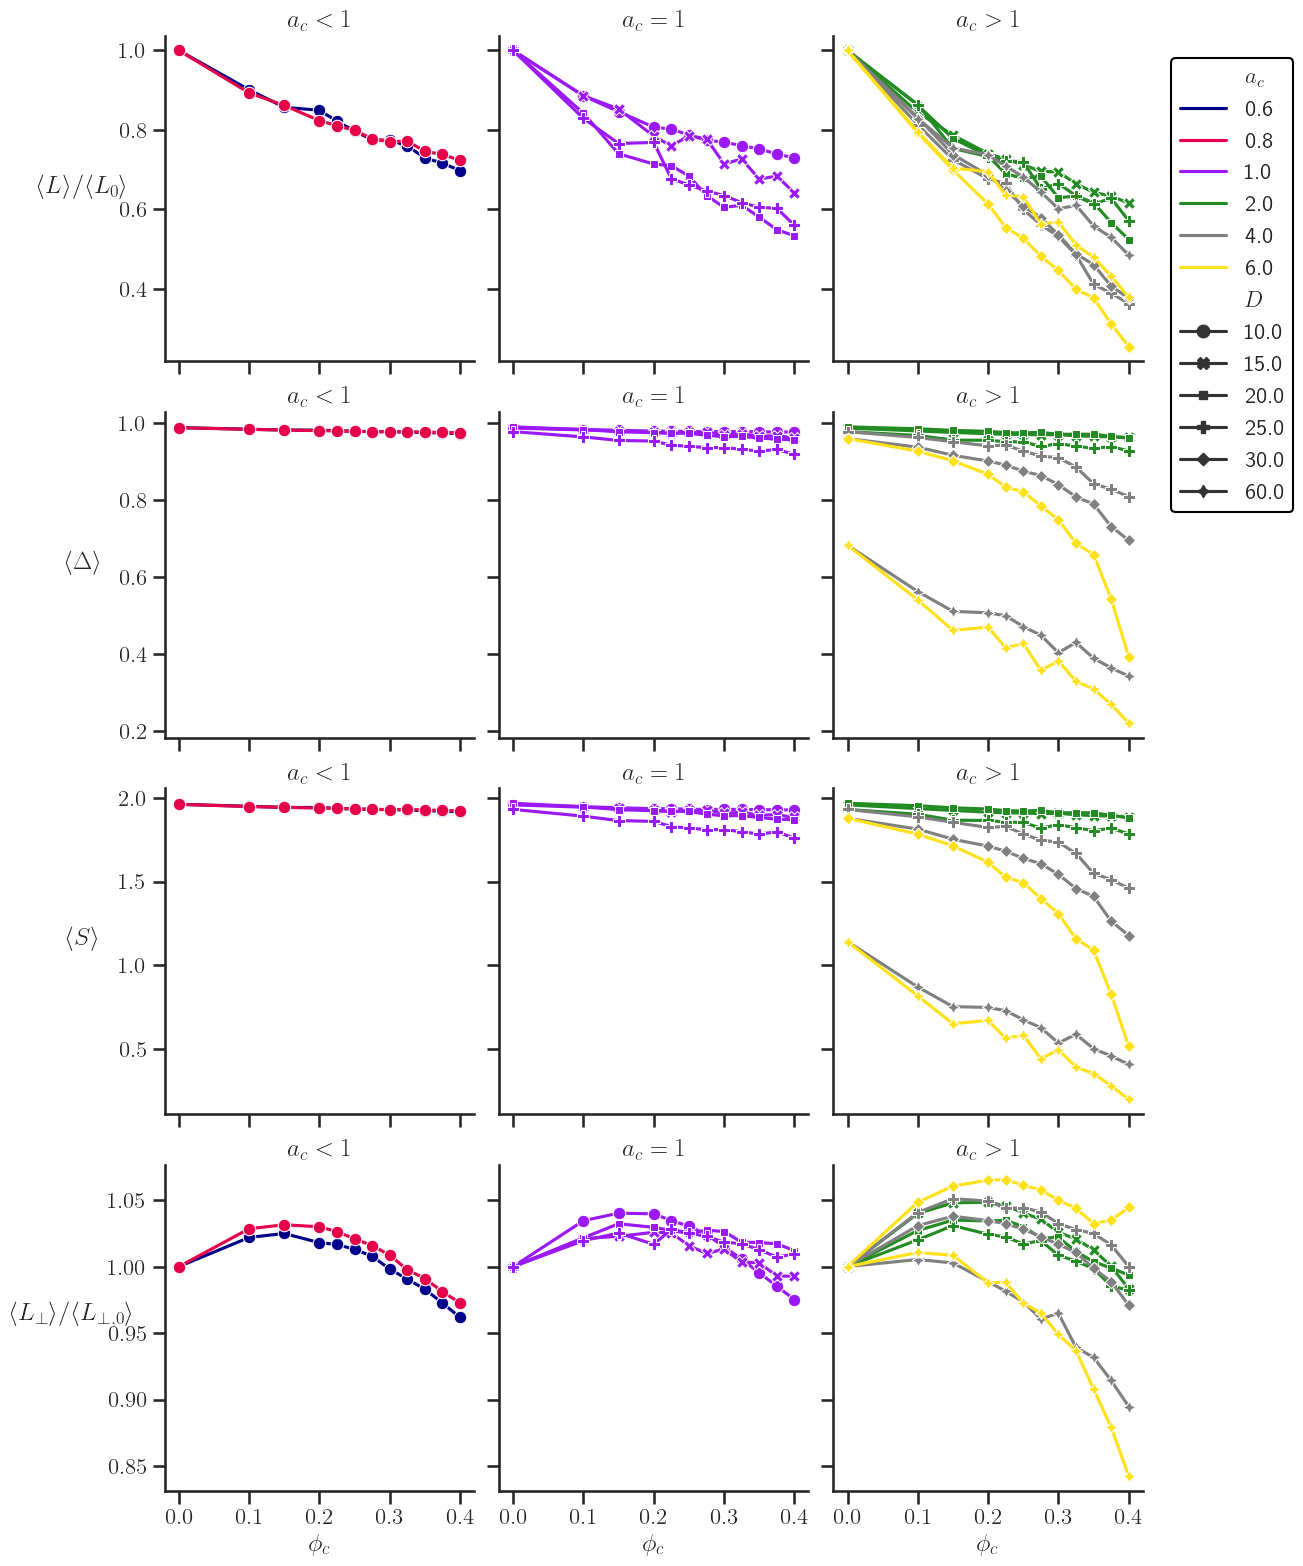

In [7]:
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
ylabel_pad=25

x_prop = 'phi_c_bulk_round'
y_prop = 'value'

row_attr = 'variable'
row_order = norm_props

col_attr = 'size_ratio'
col_order = sorted(chainsize_melted[col_attr].unique())

style_attr = 'dcyl'
style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

#size_attr = 'dcrowd'
#size_order = sorted(chainsize_melted[size_attr].unique())
#sizes=[1+1.5*i for i in range(len(size_order))]
# The three lines below are for transc foci

hue_attr = 'dcrowd'
hue_order = sorted(chainsize_melted[hue_attr].unique())

sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)

grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    markers=True,
    dashes=False,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws
)
grid.set_titles('')
grid.set_titles(AL[col_attr] + "{col_name}")
grid.set_xlabels(AL[x_prop])
grid.set(xticks=np.arange(0,0.5,0.1))

for ax, prop in zip(grid.axes[:,0], row_order):
    ax.set_ylabel(
        AL[prop],
        rotation=0,
        labelpad=ylabel_pad
    )
legend_labels = ([AL[hue_attr]] + list(hue_order) +
                 [AL[style_attr]] + list(style_order))
for idx, new_label in enumerate(legend_labels):
    grid._legend.texts[idx].set_text(new_label)
sns.move_legend(
    grid,
    loc='upper left',
    bbox_to_anchor=(0.89, 0.96),
    **legend_kws)
grid.tight_layout(w_pad=0.5,h_pad=0.5)
#grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, 'chainMeasures', norm_style,
                   x_prop, row_attr, hue_attr,style_attr]
                 )
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300,  backend='pgf')
#plt.close()

### S and Delta nomred

In [8]:
x_prop = 'phi_c_bulk_round'
y_prop = 'value'

row_attr = 'variable'
row_order = norm_props

#col_attr = 'dcyl'
#col_order = sorted(chainsize_melted[col_attr].unique())

style_attr = 'nmon'
style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

size_attr = 'dcyl'
size_order = sorted(chainsize_melted[size_attr].unique())
sizes=[1+1.5*i for i in range(len(size_order))]

# The three lines below are for transc foci
hue_attr = 'dcrowd'
hue_order = sorted(chainsize_melted[hue_attr].unique())
#color_palette = sns.set_palette('magma_r', len(hue_order))
#color_palette = 'rocket_r'
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 1.5
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
tseries_grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    size=size_attr,
    size_order=size_order,
    sizes=sizes,
    markers=True,
    dashes=False,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=15,
#    markevery=10
)
for ax, prop, ystep in zip(tseries_grid.axes[:,0], row_order,[0.2,0.2,0.2,0.2,0.2]):
    #ymin, ymax = ax.get_ylim()
    #ymin = utilizer.round_up_nearest(ymin, 0.2, 1)
    #ymax = utilizer.round_up_nearest(ymax, 0.2, 1)
    ax.set_ylabel(AL[prop])
    #ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    #ax.set_ylim(ymin-0.2*ystep, ymax+0.2*ystep)
    ax.set_title("")
tseries_grid.fig.align_ylabels()
#tseries_grid.set_titles(AL[row_attr] + r"$={row_name}$")
tseries_grid.set_xlabels(AL[x_prop])
tseries_grid.tight_layout(w_pad=1)
legend_labels = [AL[hue_attr]] + list(hue_order)  + \
    [AL[size_attr]] + list(size_order) +  \
        [AL[style_attr]] + list(style_order)
for idx, new_label in enumerate(legend_labels):
    tseries_grid._legend.texts[idx].set_text(new_label)
sns.move_legend(tseries_grid, loc=loc, **move_legend_kws)
tseries_grid.set(
    xticks=np.arange(0,0.5,0.1)
)
sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
tseries_grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, x_prop, row_attr, hue_attr,style_attr, size_attr, 'chainMeasures'])
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

### a_c=a

NameError: name 'properties_labels' is not defined

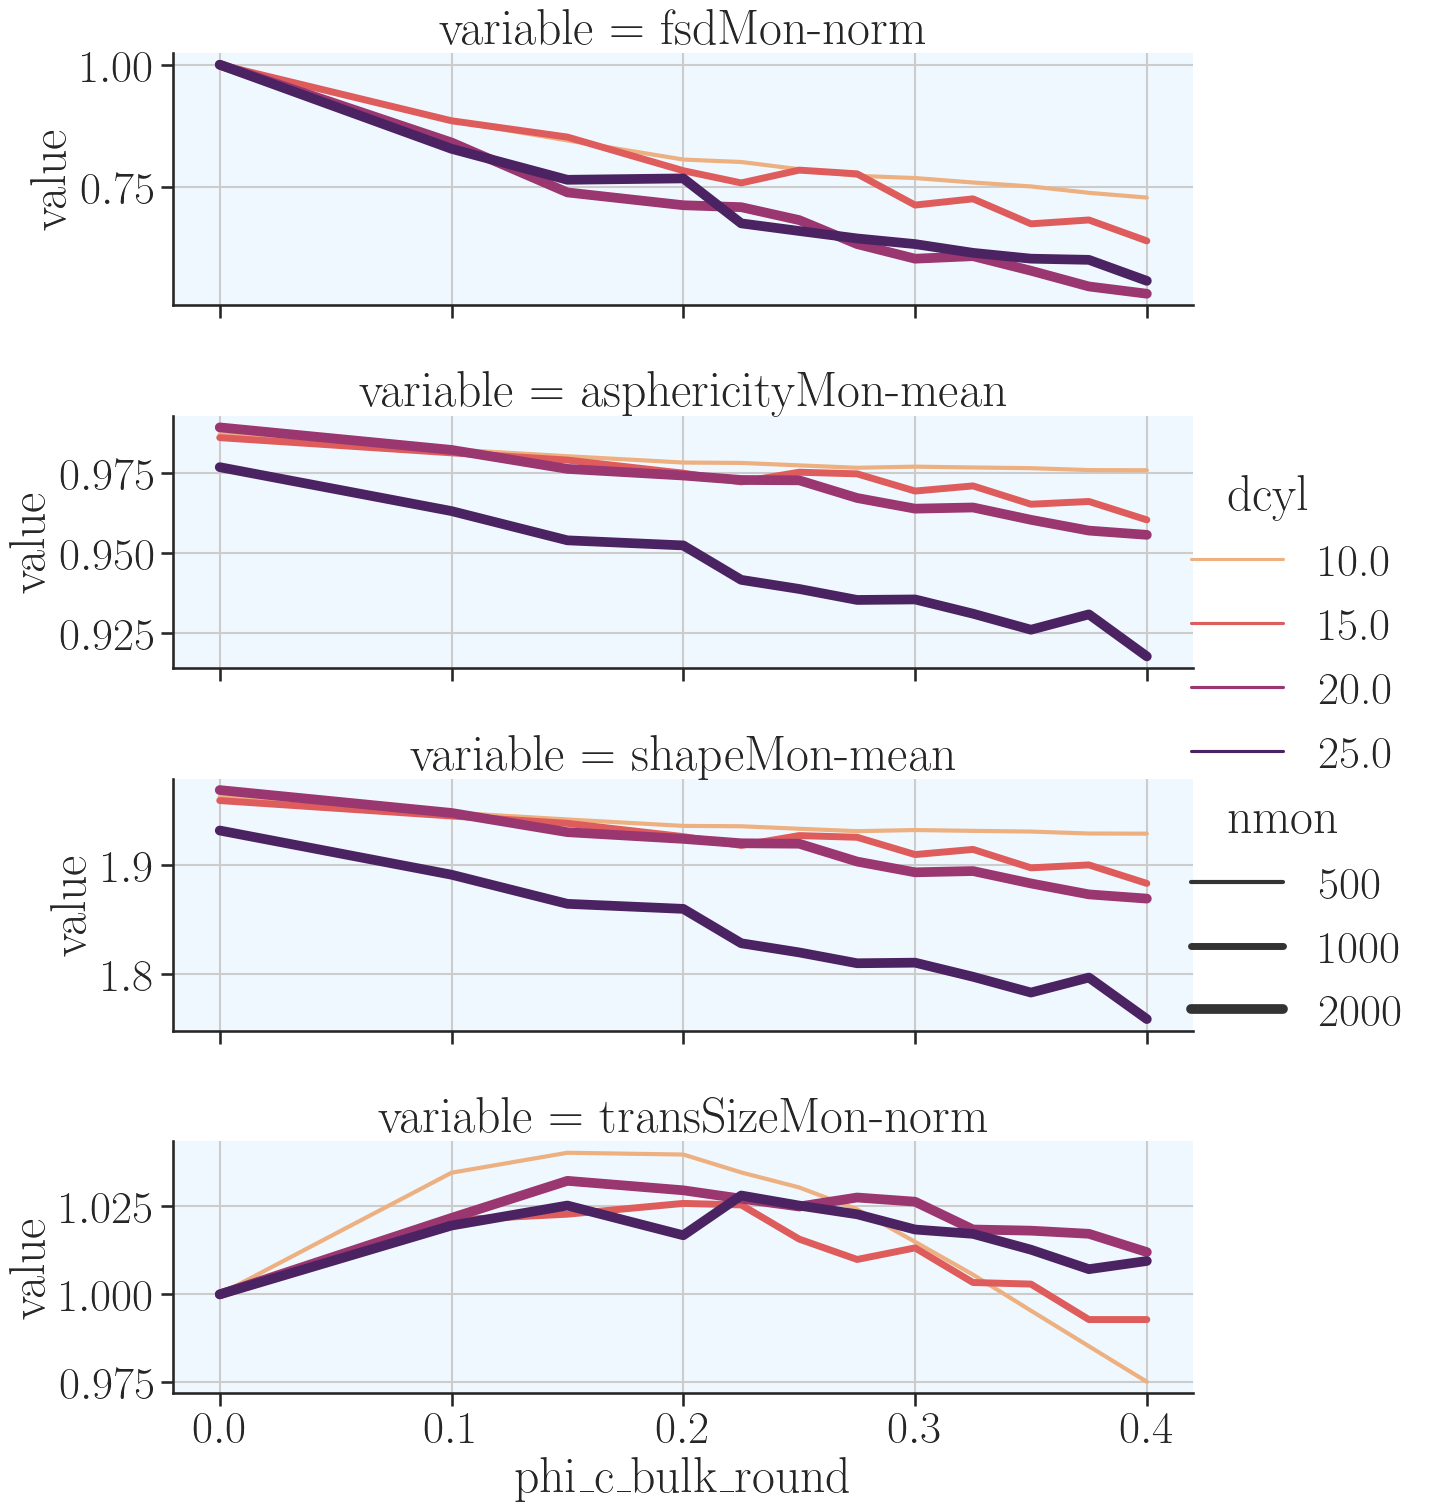

In [9]:
dcrowd_cond = (chainsize_melted['dcrowd'].isin([1.0]))
cond = dcrowd_cond
data = chainsize_melted.loc[cond, :].copy()
x_prop = 'phi_c_bulk_round'
y_prop = 'value'

col_attr = 'variable'
row_order = norm_props

#col_attr = 'dcyl'
#col_order = sorted(chainsize_melted[col_attr].unique())

#style_attr = 'dcyl'
#style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

size_attr = 'nmon'
size_order = sorted(data[size_attr].unique())
sizes=[3+2*i for i in range(len(size_order))]

# The three lines below are for transc foci
hue_attr = 'dcyl'
hue_order = sorted(data[hue_attr].unique())
#color_palette = sns.set_palette('magma_r', len(hue_order))
#color_palette = 'rocket_r'
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 2
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
tseries_grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    #style=style_attr,
    #style_order=style_order,
    size=size_attr,
    size_order=size_order,
    sizes=sizes,
    markers=True,
    dashes=True,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=10,
    markevery=10
)
for ax, prop, ystep in zip(tseries_grid.axes[:,0], row_order,[0.2,0.1,0.2,0.02,0.05]):
    ymin, ymax = ax.get_ylim()
    ymin = utilizer.round_up_nearest(ymin, ystep, 2)
    ymax = utilizer.round_up_nearest(ymax, ystep, 1)
    ax.set_ylabel(
        properties_labels[project][prop]["symbol"],
        rotation=0,
        labelpad=ylabel_pad
    )
    ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    ax.set_ylim(ymin-0.5*ystep, ymax+0.5*ystep)
    ax.set_title("")
#tseries_grid.set_titles(AL[row_attr] + r"$={row_name}$")
tseries_grid.set_xlabels(AL[x_prop])
tseries_grid.tight_layout(w_pad=1)
legend_labels = ([AL[hue_attr]] + list(hue_order)  + \
    [AL[size_attr]] + list(size_order)# +  \
        #[AL[style_attr]] + list(style_order)
                )
for idx, new_label in enumerate(legend_labels):
    #tseries_grid._legend.legendHandles[idx].set_linewidth(7)
    tseries_grid._legend.texts[idx].set_ha('left')
    tseries_grid._legend.texts[idx].set_text(new_label)
sns.move_legend(tseries_grid, loc=loc, **move_legend_kws)
tseries_grid.set(
    xticks=np.arange(0,0.5,0.1)
)
sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
tseries_grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, x_prop, row_attr, hue_attr,style_attr, size_attr, 'chainMeasures-DcrowdEqualDmon'])
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

### Averaging over $t>t_{equilibrate}$ where $t_{equilibrate}$ changing with ensemble_long

In [ ]:
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps', phase]
)
norm_style = 'norm'
normalization = {
    'mean': ['fsdMon-norm',# 'gyrMon-norm', , 'rfloryMon-norm',
             'asphericityMon-norm', 'shapeMon-norm',
             'transSizeMon-norm'],
    'norm': ['fsdMon-norm',# 'gyrMon-norm', , 'rfloryMon-norm',
             'asphericityMon-mean', 'shapeMon-mean',
             'transSizeMon-norm'],
    'var': ['fsdMon-var',# 'gyrMon-var', 'rfloryMon-var',
             'asphericityMon-var', 'shapeMon-var',
             'transSizeMon-var']
}
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)
# add a column for crowder relative size
chainsize_equil['size_ratio'] = \
    chainsize_equil['dcrowd'].apply(lambda x: measurer.size_ratio(x))
print("Equilibrium chain size columns:" , chainsize_equil.columns)
# phi_c to drop
if project == 'HnsCyl':
    chainsize_equil['phi_c_bulk_round'].replace(0.09,0.08, inplace=True)
    chainsize_equil['phi_c_bulk_round'].replace(0.15,0.16, inplace=True)
    chainsize_equil['phi_c_bulk_round'].replace(0.21,0.2, inplace=True)
    chainsize_equil['phi_c_bulk_round'].replace(0.31,0.32, inplace=True)
    chainsize_equil = chainsize_equil.loc[~chainsize_equil['phi_c_bulk_round'].isin([0.06, 0.18]),:]
if project == 'TransFociCyl':
    chainsize_equil = chainsize_equil.loc[~chainsize_equil['phi_c_bulk_round'].isin([0.025, 0.05, 0.075, 0.125, 0.175]),:]
print('unique phi_c_bulk:', sorted(chainsize_equil['phi_c_bulk_round'].unique()))
chainsize_equil.reset_index(inplace=True, drop=True)
chainsize_equil['transSizeMon-norm-dcyl'] = (2 * chainsize_equil['transSizeMon']) / chainsize_equil['dcyl'] 
# selecting 'norm' measures of properties
print(chainsize_equil.columns)
attributes = PD[project]['equil_attributes']
#norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
norm_props = normalization[norm_style]
selected_cols = attributes + norm_props
value_vars = norm_props
#gyr_fsd_only_norm_props = [
#    'gyrMon-norm', 'fsdMon-norm', 'asphericityMon-mean', 'shapeMon-mean'
#]
#selected_cols = attributes + gyr_fsd_only_norm_props
#value_vars = gyr_fsd_only_norm_props
# melting properties columns
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=value_vars
)
chainsize_melted['confinement_rate'] = np.round(
        (chainsize_melted['dcrowd'] /
         (chainsize_melted['dcyl'] - chainsize_melted['dcrowd'])), 3
)
print("Unique variables: ", chainsize_melted.variable.unique())

### S and Delta not named

In [ ]:
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger'}
height = 4
aspect = 1
font_scale = 1
font_family = 'sans-serif' # 'Times New Roman'
plot_context = 'talk'
color_palette = AC
save_to = '../../test_plots/'
ext = 'pdf'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'markerscale': 1
}
bbox_global_set = dict(boxstyle="round,pad=0.05", edgecolor='white', color='white', alpha=0.7)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)

In [ ]:
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
ylabel_pad=25

x_prop = 'phi_c_bulk_round'
y_prop = 'value'

row_attr = 'variable'
row_order = norm_props

col_attr = 'size_ratio'
col_order = sorted(chainsize_melted[col_attr].unique())

style_attr = 'dcyl'
style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

#size_attr = 'dcrowd'
#size_order = sorted(chainsize_melted[size_attr].unique())
#sizes=[1+1.5*i for i in range(len(size_order))]
# The three lines below are for transc foci

hue_attr = 'dcrowd'
hue_order = sorted(chainsize_melted[hue_attr].unique())

sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)

grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    markers=True,
    dashes=False,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws
)
grid.set_titles('')
grid.set_titles(AL[col_attr] + "{col_name}")
grid.set_xlabels(AL[x_prop])
grid.set(xticks=np.arange(0,0.5,0.1))

for ax, prop in zip(grid.axes[:,0], row_order):
    ax.set_ylabel(
        AL[prop],
        rotation=0,
        labelpad=ylabel_pad
    )
legend_labels = ([AL[hue_attr]] + list(hue_order) +
                 [AL[style_attr]] + list(style_order))
for idx, new_label in enumerate(legend_labels):
    grid._legend.texts[idx].set_text(new_label)
sns.move_legend(
    grid,
    loc='upper left',
    bbox_to_anchor=(0.89, 0.96),
    **legend_kws)
grid.tight_layout(w_pad=0.5,h_pad=0.5)
#grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, 'chainMeasures', norm_style,
                   x_prop, row_attr, hue_attr,style_attr]
                 )
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300,  backend='pgf')
#plt.close()

### S and Delta nomred

In [ ]:
x_prop = 'phi_c_bulk_round'
y_prop = 'value'

row_attr = 'variable'
row_order = norm_props

#col_attr = 'dcyl'
#col_order = sorted(chainsize_melted[col_attr].unique())

style_attr = 'nmon'
style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

size_attr = 'dcyl'
size_order = sorted(chainsize_melted[size_attr].unique())
sizes=[1+1.5*i for i in range(len(size_order))]

# The three lines below are for transc foci
hue_attr = 'dcrowd'
hue_order = sorted(chainsize_melted[hue_attr].unique())
#color_palette = sns.set_palette('magma_r', len(hue_order))
#color_palette = 'rocket_r'
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 1.5
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
tseries_grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    size=size_attr,
    size_order=size_order,
    sizes=sizes,
    markers=True,
    dashes=False,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=15,
#    markevery=10
)
for ax, prop, ystep in zip(tseries_grid.axes[:,0], row_order,[0.2,0.2,0.2,0.2,0.2]):
    #ymin, ymax = ax.get_ylim()
    #ymin = utilizer.round_up_nearest(ymin, 0.2, 1)
    #ymax = utilizer.round_up_nearest(ymax, 0.2, 1)
    ax.set_ylabel(AL[prop])
    #ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    #ax.set_ylim(ymin-0.2*ystep, ymax+0.2*ystep)
    ax.set_title("")
tseries_grid.fig.align_ylabels()
#tseries_grid.set_titles(AL[row_attr] + r"$={row_name}$")
tseries_grid.set_xlabels(AL[x_prop])
tseries_grid.tight_layout(w_pad=1)
legend_labels = [AL[hue_attr]] + list(hue_order)  + \
    [AL[size_attr]] + list(size_order) +  \
        [AL[style_attr]] + list(style_order)
for idx, new_label in enumerate(legend_labels):
    tseries_grid._legend.texts[idx].set_text(new_label)
sns.move_legend(tseries_grid, loc=loc, **move_legend_kws)
tseries_grid.set(
    xticks=np.arange(0,0.5,0.1)
)
sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
tseries_grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, x_prop, row_attr, hue_attr,style_attr, size_attr, 'chainMeasures'])
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

### a_c=a

In [ ]:
dcrowd_cond = (chainsize_melted['dcrowd'].isin([1.0]))
cond = dcrowd_cond
data = chainsize_melted.loc[cond, :].copy()
x_prop = 'phi_c_bulk_round'
y_prop = 'value'

col_attr = 'variable'
row_order = norm_props

#col_attr = 'dcyl'
#col_order = sorted(chainsize_melted[col_attr].unique())

#style_attr = 'dcyl'
#style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

size_attr = 'nmon'
size_order = sorted(data[size_attr].unique())
sizes=[3+2*i for i in range(len(size_order))]

# The three lines below are for transc foci
hue_attr = 'dcyl'
hue_order = sorted(data[hue_attr].unique())
#color_palette = sns.set_palette('magma_r', len(hue_order))
#color_palette = 'rocket_r'
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 2
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
tseries_grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    #style=style_attr,
    #style_order=style_order,
    size=size_attr,
    size_order=size_order,
    sizes=sizes,
    markers=True,
    dashes=True,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=10,
    markevery=10
)
for ax, prop, ystep in zip(tseries_grid.axes[:,0], row_order,[0.2,0.1,0.2,0.02,0.05]):
    ymin, ymax = ax.get_ylim()
    ymin = utilizer.round_up_nearest(ymin, ystep, 2)
    ymax = utilizer.round_up_nearest(ymax, ystep, 1)
    ax.set_ylabel(
        properties_labels[project][prop]["symbol"],
        rotation=0,
        labelpad=ylabel_pad
    )
    ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    ax.set_ylim(ymin-0.5*ystep, ymax+0.5*ystep)
    ax.set_title("")
#tseries_grid.set_titles(AL[row_attr] + r"$={row_name}$")
tseries_grid.set_xlabels(AL[x_prop])
tseries_grid.tight_layout(w_pad=1)
legend_labels = ([AL[hue_attr]] + list(hue_order)  + \
    [AL[size_attr]] + list(size_order)# +  \
        #[AL[style_attr]] + list(style_order)
                )
for idx, new_label in enumerate(legend_labels):
    #tseries_grid._legend.legendHandles[idx].set_linewidth(7)
    tseries_grid._legend.texts[idx].set_ha('left')
    tseries_grid._legend.texts[idx].set_text(new_label)
sns.move_legend(tseries_grid, loc=loc, **move_legend_kws)
tseries_grid.set(
    xticks=np.arange(0,0.5,0.1)
)
sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
tseries_grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, x_prop, row_attr, hue_attr,style_attr, size_attr, 'chainMeasures-DcrowdEqualDmon'])
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

In [ ]:
equil_props

In [ ]:

    chainsize_ens_avg_melt = chainsize_ens_avg.melt(
        id_vars=id_cols,
        value_vars=rolling_windows_names,
        var_name='Rolling window',
        value_name='fsdTMon'
        )
    chainsize_ens_avg_melt.dropna(inplace=True)
    chainsize_ens_avg_melt_t_avg = chainsize_ens_avg_melt.groupby(group_by_cols)['fsdTMon'].mean().reset_index()
    fsd_rolled_avg.append(chainsize_ens_avg_melt_t_avg)

fsd_rolled_avg = pd.concat(fsd_rolled_avg)
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    if project not in TS.keys():
            raise ValueError(f"Project: '{project}' is not defined.")

    style = TS[project]
    cond = fsd_rolled_avg['space']==space
    fsd_rolled_avg.loc[cond,'space_title'] = style['title'](s_info)
    fsd_rolled_avg.loc[cond,'space_title_short'] = style['short'](s_info)
    fsd_rolled_avg.loc[cond,'universe'] = style['universe'](s_info)

fsd_rolled_avg.sort_values(by=['dcrowd','dcyl','nmon'], inplace=True)
fsd_rolled_avg['Rolling window'] = pd.Categorical(fsd_rolled_avg['Rolling window'], categories=rolling_windows_names, ordered=True)

### Averaging over $t>t_{equilibrate}$ where $t_{equilibrate}$ changing with ensemble_long

### Using the whole data

In [ ]:
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps', phase]
)
norm_style = 'norm'
normalization = {
    'mean': ['fsdMon-norm',# 'gyrMon-norm', , 'rfloryMon-norm',
             'asphericityMon-norm', 'shapeMon-norm',
             'transSizeMon-norm'],
    'norm': ['fsdMon-norm',# 'gyrMon-norm', , 'rfloryMon-norm',
             'asphericityMon-mean', 'shapeMon-mean',
             'transSizeMon-norm'],
    'var': ['fsdMon-var',# 'gyrMon-var', 'rfloryMon-var',
             'asphericityMon-var', 'shapeMon-var',
             'transSizeMon-var']
}
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)
# add a column for crowder relative size
chainsize_equil['size_ratio'] = \
    chainsize_equil['dcrowd'].apply(lambda x: measurer.size_ratio(x))
print("Equilibrium chain size columns:" , chainsize_equil.columns)
# phi_c to drop
if project == 'HnsCyl':
    chainsize_equil['phi_c_bulk_round'].replace(0.09,0.08, inplace=True)
    chainsize_equil['phi_c_bulk_round'].replace(0.15,0.16, inplace=True)
    chainsize_equil['phi_c_bulk_round'].replace(0.21,0.2, inplace=True)
    chainsize_equil['phi_c_bulk_round'].replace(0.31,0.32, inplace=True)
    chainsize_equil = chainsize_equil.loc[~chainsize_equil['phi_c_bulk_round'].isin([0.06, 0.18]),:]
if project == 'TransFociCyl':
    chainsize_equil = chainsize_equil.loc[~chainsize_equil['phi_c_bulk_round'].isin([0.025, 0.05, 0.075, 0.125, 0.175]),:]
print('unique phi_c_bulk:', sorted(chainsize_equil['phi_c_bulk_round'].unique()))
chainsize_equil.reset_index(inplace=True, drop=True)
chainsize_equil['transSizeMon-norm-dcyl'] = (2 * chainsize_equil['transSizeMon']) / chainsize_equil['dcyl'] 
# selecting 'norm' measures of properties
print(chainsize_equil.columns)
attributes = PD[project]['equil_attributes']
#norm_props = [prop for prop in chainsize_equil.columns if prop.endswith('-norm')]
norm_props = normalization[norm_style]
selected_cols = attributes + norm_props
value_vars = norm_props
#gyr_fsd_only_norm_props = [
#    'gyrMon-norm', 'fsdMon-norm', 'asphericityMon-mean', 'shapeMon-mean'
#]
#selected_cols = attributes + gyr_fsd_only_norm_props
#value_vars = gyr_fsd_only_norm_props
# melting properties columns
chainsize_melted = chainsize_equil[selected_cols].melt(
    id_vars=attributes,
    value_vars=value_vars
)
chainsize_melted['confinement_rate'] = np.round(
        (chainsize_melted['dcrowd'] /
         (chainsize_melted['dcyl'] - chainsize_melted['dcrowd'])), 3
)
print("Unique variables: ", chainsize_melted.variable.unique())

#### S and Delta not named

In [ ]:
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger'}
height = 4
aspect = 1
font_scale = 1
font_family = 'sans-serif' # 'Times New Roman'
plot_context = 'talk'
color_palette = AC
save_to = '../../test_plots/'
ext = 'pdf'
rc_params = {
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': True,
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'ncol': 1,
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    'edgecolor': 'black',
    'markerscale': 1
}
bbox_global_set = dict(boxstyle="round,pad=0.05", edgecolor='white', color='white', alpha=0.7)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)

In [ ]:
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
ylabel_pad=25

x_prop = 'phi_c_bulk_round'
y_prop = 'value'

row_attr = 'variable'
row_order = norm_props

col_attr = 'size_ratio'
col_order = sorted(chainsize_melted[col_attr].unique())

style_attr = 'dcyl'
style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

#size_attr = 'dcrowd'
#size_order = sorted(chainsize_melted[size_attr].unique())
#sizes=[1+1.5*i for i in range(len(size_order))]
# The three lines below are for transc foci

hue_attr = 'dcrowd'
hue_order = sorted(chainsize_melted[hue_attr].unique())

sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)

grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    col=col_attr,
    col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    markers=True,
    dashes=False,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws
)
grid.set_titles('')
grid.set_titles(AL[col_attr] + "{col_name}")
grid.set_xlabels(AL[x_prop])
grid.set(xticks=np.arange(0,0.5,0.1))

for ax, prop in zip(grid.axes[:,0], row_order):
    ax.set_ylabel(
        AL[prop],
        rotation=0,
        labelpad=ylabel_pad
    )
legend_labels = ([AL[hue_attr]] + list(hue_order) +
                 [AL[style_attr]] + list(style_order))
for idx, new_label in enumerate(legend_labels):
    grid._legend.texts[idx].set_text(new_label)
sns.move_legend(
    grid,
    loc='upper left',
    bbox_to_anchor=(0.89, 0.96),
    **legend_kws)
grid.tight_layout(w_pad=0.5,h_pad=0.5)
#grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, 'chainMeasures', norm_style,
                   x_prop, row_attr, hue_attr,style_attr]
                 )
grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300,  backend='pgf')
#plt.close()

#### S and Delta nomred

In [ ]:
x_prop = 'phi_c_bulk_round'
y_prop = 'value'

row_attr = 'variable'
row_order = norm_props

#col_attr = 'dcyl'
#col_order = sorted(chainsize_melted[col_attr].unique())

style_attr = 'nmon'
style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

size_attr = 'dcyl'
size_order = sorted(chainsize_melted[size_attr].unique())
sizes=[1+1.5*i for i in range(len(size_order))]

# The three lines below are for transc foci
hue_attr = 'dcrowd'
hue_order = sorted(chainsize_melted[hue_attr].unique())
#color_palette = sns.set_palette('magma_r', len(hue_order))
#color_palette = 'rocket_r'
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 1.5
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
tseries_grid = sns.relplot(
    data=chainsize_melted,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    style=style_attr,
    style_order=style_order,
    size=size_attr,
    size_order=size_order,
    sizes=sizes,
    markers=True,
    dashes=False,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=15,
#    markevery=10
)
for ax, prop, ystep in zip(tseries_grid.axes[:,0], row_order,[0.2,0.2,0.2,0.2,0.2]):
    #ymin, ymax = ax.get_ylim()
    #ymin = utilizer.round_up_nearest(ymin, 0.2, 1)
    #ymax = utilizer.round_up_nearest(ymax, 0.2, 1)
    ax.set_ylabel(AL[prop])
    #ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    #ax.set_ylim(ymin-0.2*ystep, ymax+0.2*ystep)
    ax.set_title("")
tseries_grid.fig.align_ylabels()
#tseries_grid.set_titles(AL[row_attr] + r"$={row_name}$")
tseries_grid.set_xlabels(AL[x_prop])
tseries_grid.tight_layout(w_pad=1)
legend_labels = [AL[hue_attr]] + list(hue_order)  + \
    [AL[size_attr]] + list(size_order) +  \
        [AL[style_attr]] + list(style_order)
for idx, new_label in enumerate(legend_labels):
    tseries_grid._legend.texts[idx].set_text(new_label)
sns.move_legend(tseries_grid, loc=loc, **move_legend_kws)
tseries_grid.set(
    xticks=np.arange(0,0.5,0.1)
)
sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
tseries_grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, x_prop, row_attr, hue_attr,style_attr, size_attr, 'chainMeasures'])
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

#### a_c=a

In [ ]:
dcrowd_cond = (chainsize_melted['dcrowd'].isin([1.0]))
cond = dcrowd_cond
data = chainsize_melted.loc[cond, :].copy()
x_prop = 'phi_c_bulk_round'
y_prop = 'value'

col_attr = 'variable'
row_order = norm_props

#col_attr = 'dcyl'
#col_order = sorted(chainsize_melted[col_attr].unique())

#style_attr = 'dcyl'
#style_order = sorted(chainsize_melted[style_attr].unique())
#markers=['o', 'o', '^'],
#dashes=[(2, 2), (2, 2), (1, 0)],

size_attr = 'nmon'
size_order = sorted(data[size_attr].unique())
sizes=[3+2*i for i in range(len(size_order))]

# The three lines below are for transc foci
hue_attr = 'dcyl'
hue_order = sorted(data[hue_attr].unique())
#color_palette = sns.set_palette('magma_r', len(hue_order))
#color_palette = 'rocket_r'
color_palette = 'flare'
#color_palette = 'tab10'
#color_palette = ['orange', 'darkgoldenrod', 'forestgreen']
save_to = './'
ext = 'pdf'
plot_context = 'talk'
font_scale = 2
height = 4
aspect = 2*1.618
ylabel_pad = 50
rc_params= {
    'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    'axes.grid': True,
    'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True,
}
fig_title_kws = {'fontsize': 34, 'x': 0.5, 'y': 0.93}
loc='lower left'
font_family = 'sans-serif'
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (1., 0.95),
    'frameon': True,
    'facecolor': 'aliceblue',
    #'borderpad': 0.1,
    'markerscale': 2
}
sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font='Times New Roman',
    font_scale=font_scale,
    rc=rc_params
)
tseries_grid = sns.relplot(
    data=data,
    x=x_prop,
    y=y_prop,
    #col=col_attr,
    #col_order=col_order,
    row=row_attr,
    row_order=row_order,
    hue=hue_attr,
    hue_order=hue_order,
    #style=style_attr,
    #style_order=style_order,
    size=size_attr,
    size_order=size_order,
    sizes=sizes,
    markers=True,
    dashes=True,
    legend='full',
    kind='line',
    height=height,
    aspect=aspect,
    palette=color_palette,
    facet_kws=facet_kws,
    markersize=10,
    markevery=10
)
for ax, prop, ystep in zip(tseries_grid.axes[:,0], row_order,[0.2,0.1,0.2,0.02,0.05]):
    ymin, ymax = ax.get_ylim()
    ymin = utilizer.round_up_nearest(ymin, ystep, 2)
    ymax = utilizer.round_up_nearest(ymax, ystep, 1)
    ax.set_ylabel(
        properties_labels[project][prop]["symbol"],
        rotation=0,
        labelpad=ylabel_pad
    )
    ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    ax.set_ylim(ymin-0.5*ystep, ymax+0.5*ystep)
    ax.set_title("")
#tseries_grid.set_titles(AL[row_attr] + r"$={row_name}$")
tseries_grid.set_xlabels(AL[x_prop])
tseries_grid.tight_layout(w_pad=1)
legend_labels = ([AL[hue_attr]] + list(hue_order)  + \
    [AL[size_attr]] + list(size_order)# +  \
        #[AL[style_attr]] + list(style_order)
                )
for idx, new_label in enumerate(legend_labels):
    #tseries_grid._legend.legendHandles[idx].set_linewidth(7)
    tseries_grid._legend.texts[idx].set_ha('left')
    tseries_grid._legend.texts[idx].set_text(new_label)
sns.move_legend(tseries_grid, loc=loc, **move_legend_kws)
tseries_grid.set(
    xticks=np.arange(0,0.5,0.1)
)
sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
tseries_grid.fig.tight_layout(pad=0)
output = "-".join(["equilPlot", project, x_prop, row_attr, hue_attr,style_attr, size_attr, 'chainMeasures-DcrowdEqualDmon'])
tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight', dpi=300)
plt.close()

## Time series of physical properties

### per property per space phi_c as hue

In [ ]:
%%time 
# ~10min
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'phi_c_bulk_round'
x_prop = 't_index' # 'time'

for plot_context in ['paper', 'talk']:
    for x_axis_style in ['normal', 'log']:
        for space in spaces:
            chainsize_space = chainsize.loc[chainsize['space']==space]
            for y_prop in properties:
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        tseries_grid = sns.lineplot(
                            data=chainsize_space,
                            x=x_prop,
                            y=y_prop,
                            hue=hue_attr,
                            legend='full',
                            palette=color_palette,
                            errorbar=None,
                            alpha=0.7
                        )
                        if plot_context == 'talk':
                            tseries_grid.set_title(
                                chainsize_space['space_title'].values[0],
                            )
                        tseries_grid.set_xlabel(AL[x_prop])
                        tseries_grid.set_ylabel(SML[y_prop]['symbol'])
                        tseries_grid.legend(title=AL[hue_attr],
                                            loc='upper left',
                                            bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                            **legend_kws
                                        )
                        if x_axis_style == 'log':
                            tseries_grid.set(xscale="log")
                        output = "-".join(
                            ["Time_evolution", plot_context, x_axis_style, y_prop, project, space]
                        )
                        plt.savefig(save_to+output+"."+ext, bbox_inches='tight')
                        plt.close()

### per property per space selected phi_c as hue

In [ ]:
%%time 
# ~6min
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = 'viridis'
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'phi_c_bulk_round'
x_prop = 't_index' # 'time'
phi_c_chosen = [0, 0.1, 0.2, 0.3, 0.4]

for plot_context in ['paper', 'talk']:
    for x_axis_style in ['normal', 'log']:
        for space in spaces:
            cond_phi_c = chainsize['phi_c_bulk_round'].isin(phi_c_chosen)
            cond_space = chainsize['space']==space 
            chainsize_space = chainsize.loc[cond_phi_c&cond_space]
            for y_prop in properties:
                sns.reset_defaults()
                with sns.axes_style('ticks', rc=rc_params):
                    with sns.plotting_context(
                    plot_context,
                    font_scale=plot_params[plot_context]['font_scale']
                    ):
                        tseries_grid = sns.lineplot(
                            data=chainsize_space,
                            x=x_prop,
                            y=y_prop,
                            hue=hue_attr,
                            legend='full',
                            palette=color_palette,
                            errorbar=None,
                            alpha=0.7
                        )
                        if plot_context == 'talk':
                            tseries_grid.set_title(
                                chainsize_space['space_title'].values[0],
                            )
                        tseries_grid.set_xlabel(AL[x_prop])
                        tseries_grid.set_ylabel(SML[y_prop]['symbol'])
                        tseries_grid.legend(title=AL[hue_attr],
                                            loc='upper left',
                                            bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                            **legend_kws
                                        )
                        if x_axis_style == 'log':
                            tseries_grid.set(xscale="log")
                        output = "-".join(
                            ["Time_evolution-chosen_phic", plot_context, x_axis_style, y_prop, project, space]
                        )
                        plt.savefig(save_to+output+"."+ext, bbox_inches='tight')
                        plt.close()

### per property selected space selected phi_c as hue

##### style 1

In [ ]:
%%time 
# ~6min
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 5,
        'aspect': 1, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2,
        'bbox_to_anchor':(0.72, 0.9),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': False,
    'ytick.right': False,
    'font_family': font_family
}

facet_kws = {'sharey': False, 'sharex': True}#, 'legend_out': True}
legend_kws = {'ncol': 1, 'frameon': False}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}
phi_c_chosen = [0, 0.1, 0.2, 0.3, 0.4]
cond_phi_c = chainsize['phi_c_bulk_round'].isin(phi_c_chosen)
spaces_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    '$N=500, D=10.0, a_c=1.0$',
    '$N=2000, D=30.0, a_c=4.0$',
    '$N=2000, D=30.0, a_c=6.0$'
    ]
cond_space = chainsize['space_title'].isin(spaces_chosen)

chainsize_chosen = chainsize.loc[cond_phi_c&cond_space]
col_attr = 'space_title'
col_order = spaces_chosen
color_palette = 'viridis_r'
hue_attr = 'phi_c_bulk_round'
x_prop = 't_index' # 'time'
for plot_context in ['paper']:
    for x_axis_style in ['log']:
        for y_prop in properties[1:2]:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    tseries_grid = sns.relplot(
                        data=chainsize_chosen,
                        x=x_prop,
                        y=y_prop,
                        col=col_attr,
                        col_order=col_order,
                        hue=hue_attr,
                        legend='full',
                        palette=color_palette,
                        kind='line',
                        errorbar=None,
                        aspect=plot_params[plot_context]['aspect'],
                        height=plot_params[plot_context]['height'],
                        facet_kws=facet_kws,
                        alpha=0.9
                    )
                    tseries_grid.set_titles("{col_name}")
                    tseries_grid.set_xlabels(AL[x_prop])
                    tseries_grid.set_ylabels(SML[y_prop]['symbol'])
                    tseries_grid.set(xscale="log")
                    #tseries_grid._legend.set_title(AL[hue_attr])
                    for legobj in tseries_grid._legend.legendHandles:
                        legobj.set_linewidth(3.0)
                    sns.move_legend(tseries_grid, title=AL[hue_attr],
                                    loc='upper left',
                                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                    **legend_kws
                    )
                    #tseries_grid.tight_layout(pad=0.1)
                    output = "-".join(
                        ["Time_evolution-chosen_spaces_phic-style1", plot_context, x_axis_style, y_prop, project]
                    )
                    tseries_grid.savefig(save_to+output+"."+ext, bbox_inches='tight')
                    plt.close()

##### style 2

In [ ]:
%%time 
# ~6min
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1,
        'bbox_to_anchor':(1.02, 1.1),
    },
    'paper': {
        'height': 4,
        'aspect': 1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2,
        'bbox_to_anchor':(0.5, 0.5),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': False,
    'ytick.right': False,
    'font_family': font_family
}
facet_kws = {'sharey': False, 'sharex': True}#, 'legend_out': True}
legend_kws = {'ncol': 2, 'frameon': False, 'markerscale': 2}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}
phi_c_chosen = [0, 0.1, 0.2, 0.3, 0.4]
cond_phi_c = chainsize['phi_c_bulk_round'].isin(phi_c_chosen)
spaces_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    '$N=500, D=10.0, a_c=1.0$',
    '$N=2000, D=30.0, a_c=4.0$',
    '$N=2000, D=30.0, a_c=6.0$'
    ]
cond_space = chainsize['space_title'].isin(spaces_chosen)

chainsize_chosen = chainsize.loc[cond_phi_c&cond_space]
col_attr = 'space_title'
col_order = spaces_chosen
hue_attr = 'phi_c_bulk_round'
color_palette = 'viridis_r'
x_prop = 't_index' # 'time'
for plot_context in ['paper']:
    for x_axis_style in ['log']:
        for y_prop in properties[1:2]:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    tseries_grid = sns.relplot(
                        data=chainsize_chosen,
                        x=x_prop,
                        y=y_prop,
                        col=col_attr,
                        col_order=col_order,
                        col_wrap=2,
                        hue=hue_attr,
                        legend='full',
                        palette=color_palette,
                        kind='line',
                        errorbar=None,
                        aspect=plot_params[plot_context]['aspect'],
                        height=plot_params[plot_context]['height'],
                        facet_kws=facet_kws,
                        alpha=0.9
                    )
                    tseries_grid.set_titles("{col_name}")
                    tseries_grid.set_xlabels(AL[x_prop])
                    tseries_grid.set_ylabels(SML[y_prop]['symbol'])
                    tseries_grid.set(xscale="log")
                    #tseries_grid._legend.set_title(AL[hue_attr])
                    for legobj in tseries_grid._legend.legendHandles:
                        legobj.set_linewidth(3.0)
                    sns.move_legend(tseries_grid, title=AL[hue_attr],
                                    loc='upper left',
                                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                    **legend_kws
                    )
                    #tseries_grid.tight_layout(pad=0.1)
                    output = "-".join(
                        ["Time_evolution-chosen_spaces_phic-style2", plot_context, x_axis_style, y_prop, project]
                    )
                    tseries_grid.savefig(save_to+output+"."+ext, bbox_inches='tight')
                    plt.close()

### per property fixed phi_c time normalized with max space as hue

#### filter data for a given phi_c, normalizing time by its max

In [ ]:
# filter for the chosen phi_c
phi_c_to_keep = [0.3]
chainsize_phi_c = chainsize.loc[chainsize['phi_c_bulk_round'].isin(phi_c_to_keep),:].copy()
chainsize_phi_c.reset_index(inplace=True)
# Calculate the normalized 't_index' values using the custom function
chainsize_phi_c.sort_values(by=['ensemble_long', 't_index'], inplace=True)
#group_sizes = chainsize_phi_c.groupby('ensemble_long').size()
#nth_perecent = 0.05
#last_nth_percent_indices = (group_sizes * (1-nth_perecent)).astype(int)
#last_nth_percent_indices = last_nth_percent_indices.reset_index()
#last_nth_percent_indices.rename(columns={0:'index'}, inplace=True)

# Calculate the size of each 'ensemble_long' group
#group_sizes = chainsize_phi_c.groupby('ensemble_long').size()

# Define the nth_percent value (5%)
nth_percent = 0.1

# Calculate the index position corresponding to the last nth_percent of data points in each 'ensemble_long' group
#last_nth_percent_indices = ((group_sizes * (1 - nth_percent))/group_sizes).astype(int).reset_index()
#last_nth_percent_indices.rename(columns={0: 'index'}, inplace=True)

#for ensemble_long in last_nth_percent_indices['ensemble_long'].values:

# probelamtic: do not use it (20230808)
for ensemble_long in chainsize_phi_c['ensemble_long'].unique():
    #print(ensemble_long)
    for y_prop in properties[1:2]:
        #print(y_prop)
        chainsize_phi_c[y_prop+'-norm-last_nth_mean'] = 0 
        cond_ens_long = chainsize_phi_c['ensemble_long'] == ensemble_long
        #nth_index = last_nth_percent_indices.loc[cond_ens_long,'index'].values[0]
        cond_t_idx_norm = chainsize_phi_c['t_norm'] >= (1-nth_percent)
        last_nth_mean = chainsize_phi_c.loc[cond_ens_long&cond_ens_long,y_prop].mean()
        #print(last_nth_mean)
        #print(chainsize_phi_c[y_prop].mean())
        chainsize_phi_c.loc[cond_ens_long, y_prop+'-norm-last_nth_mean'] = chainsize_phi_c.loc[cond_ens_long, y_prop] / last_nth_mean 
        #chainsize_y_prop.loc[last_nth_percent_indices['ensemble_long']==ensemble_long,'index'].value:, y_prop].
    cond = chainsize_phi_c['ensemble_long']==ensemble_long
    s_info = PD[project]['parser'](
        ensemble_long,
        'ensemble_long',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    chainsize_phi_c.loc[cond, 'triples'] = fr"$({s_info.nmon},{s_info.dcyl},{s_info.dcrowd})$"

print("PROLEMATIC approach: dividion by mean and  filtering does not match the range of values")
# sorting
group_by_cols = {
    'SumRuleCyl': ['nmon','dcyl','dcrowd'],
    'TransFociCub': ['nmon_large'],
    'TransFociCyl': ['nmon_large'],
    'HnsCub': ['nhns','dcrowd'],
}

chainsize_phi_c.sort_values(group_by_cols[project], inplace=True)

#### viz

##### per physical property fixed phi_c spaces as hue

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1.8),
    },
    'paper': {
        'height': 4,
        'aspect': 2*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.9,
        'bbox_to_anchor':(0., 1.83),
        #'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = AC[:len(spaces)] # dmon_large_c_palette
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 3, 'ncol': 3,
              'labelspacing': 0.3, 'handlelength': 1.5, 'handleheight': 1.5,
              'handletextpad': 0.3, 'columnspacing': 0.6}
fig_title_kws = {'x': 0.5, 'y': 1.02, 'ha': 'center'}

hue_attr = 'triples'
x_prop = 't_norm' # 'time'
t_idx_nrom_cutoff = 0.8

chosen_spaces = ['N500D10.0ac0.6', 'N500D10.0ac0.8',
                 'N500D10.0ac1.0', 'N1000D15.0ac1.0',
                 'N1000D15.0ac2.0', 'N2000D30.0ac4.0', 'N2000D30.0ac6.0']

for plot_context in ['paper']: #,'talk']:
    for y_prop in properties[1:2]:
        y_prop_norm = y_prop #+ '-norm-last_nth_mean'
        height = plot_params[plot_context]['height'] 
        aspect = plot_params[plot_context]['aspect']
        space_cond = chainsize_phi_c['space'].isin(chosen_spaces)
        full = chainsize_phi_c.loc[space_cond,[x_prop,hue_attr,y_prop,'universe']]
        trimmed = chainsize_phi_c.loc[(space_cond) & (chainsize_phi_c['t_norm']>=t_idx_nrom_cutoff),[x_prop,hue_attr, y_prop_norm,'universe']]
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
                fig, axes = plt.subplots(ncols=1,nrows=2,figsize=(height*aspect,2*height))
                # full range:
                tseries_grid = sns.lineplot(
                    data=full,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    legend=False,
                    errorbar=None,
                    alpha=0.75,
                    ax=axes[0],
                    lw=1.5,
                    palette=color_palette
                )
                tseries_grid.set_xlabel(AL[x_prop])
                tseries_grid.set_ylabel(SML[y_prop]['symbol'])
                tseries_grid.set(xscale="log")#,yscale='log')
                # trimmed range:
                tseries_grid = sns.lineplot(
                    data=trimmed,
                    x=x_prop,
                    y=y_prop_norm,
                    hue=hue_attr,
                    legend='full',
                    errorbar=None,
                    alpha=0.75,
                    ax=axes[1],
                    lw=1.5,
                    palette=color_palette
                )
                tseries_grid.set_xlabel(AL[x_prop])
                tseries_grid.set_ylabel(SML[y_prop]['symbol'])
                #tseries_grid.set(xscale="log")#,yscale='log')
                # legend:
                leg = tseries_grid.legend(
                    title=r'$(N, D, a_c)$',
                    loc='lower left',
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                    **legend_kws)
                for handler in leg.legendHandles:
                    handler.set_linewidth(3)
                fig.subplots_adjust(hspace=0.3)
                output = "-".join(
                    ["Time_evolution-xLog", y_prop, x_prop, hue_attr,
                    project, f'phi_c{phi_c_to_keep[0]}', f'tcutoff{t_idx_nrom_cutoff}'])
                fig.savefig(save_to+output+ "." + ext, bbox_inches='tight')
                plt.close()


##### 3*10^8 spaces

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1.8),
    },
    'paper': {
        'height': 4,
        'aspect': 2*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.9,
        'bbox_to_anchor':(1.02, 1.83),
        #'bbox_to_anchor':(1.02, 1),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = AC[:len(spaces)] # dmon_large_c_palette
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 3, 'ncol': 1,
              'labelspacing': 0.3, 'handlelength': 1.5, 'handleheight': 1.5,
              'handletextpad': 0.3, 'columnspacing': 0.6}
fig_title_kws = {'x': 0.5, 'y': 1.02, 'ha': 'center'}

hue_attr = 'triples'
x_prop = 't_norm' # 'time'
t_idx_nrom_cutoff = 0.5

chosen_spaces = ['N500D10.0ac0.6', 'N500D10.0ac0.8',
                 'N500D10.0ac1.0', 'N1000D15.0ac1.0',
                 'N1000D15.0ac2.0', 'N2000D30.0ac4.0', 'N2000D30.0ac6.0']
color_palette = PTM
for plot_context in ['paper']: #,'talk']:
    for y_prop in properties[1:2]:
        y_prop_norm = y_prop #+ '-norm-last_nth_mean'
        height = plot_params[plot_context]['height'] 
        aspect = plot_params[plot_context]['aspect']
        space_cond = chainsize_phi_c['space'].isin(chosen_spaces)
        full = chainsize_phi_c.loc[space_cond,[x_prop,hue_attr,y_prop,'universe']]
        trimmed = chainsize_phi_c.loc[(space_cond) & (chainsize_phi_c['t_norm']>=t_idx_nrom_cutoff),[x_prop,hue_attr, y_prop_norm,'universe']]
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
                fig, axes = plt.subplots(ncols=1,nrows=2,figsize=(height*aspect,2*height))
                # full range:
                tseries_grid = sns.lineplot(
                    data=full,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    legend=False,
                    errorbar=None,
                    alpha=0.75,
                    ax=axes[0],
                    lw=1.5,
                    palette=color_palette
                )
                tseries_grid.set_xlabel(AL[x_prop])
                tseries_grid.set_ylabel(SML[y_prop]['symbol'])
                tseries_grid.set(xscale="log")#,yscale='log')
                # trimmed range:
                tseries_grid = sns.lineplot(
                    data=trimmed,
                    x=x_prop,
                    y=y_prop_norm,
                    hue=hue_attr,
                    legend='full',
                    errorbar=None,
                    alpha=0.75,
                    ax=axes[1],
                    lw=1.5,
                    palette=color_palette
                )
                tseries_grid.yaxis.grid(True)
                tseries_grid.set_xlabel(AL[x_prop])
                tseries_grid.set_ylabel(SML[y_prop]['symbol'])
                #tseries_grid.set(xscale="log")#,yscale='log')
                # legend:
                leg = tseries_grid.legend(
                    title=fr'$\phi_c={phi_c_to_keep[0]}: (N, D, a_c)$',
                    loc='upper left',
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                    **legend_kws)
                for handler in leg.legendHandles:
                    handler.set_linewidth(3)
                fig.subplots_adjust(hspace=0.3)
                output = "-".join(
                    ["Time_evolution-xLog", y_prop, x_prop, hue_attr,
                    project, f'phi_c{phi_c_to_keep[0]}', f'tcutoff{t_idx_nrom_cutoff}'])
                fig.savefig(save_to+output+ "." + ext, bbox_inches='tight')
                plt.close()


#### physical property fixed phi_c per dcrowd: not working

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.5*1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.6,
        'bbox_to_anchor':(1.02, 1.8),
    },
    'paper': {
        'height': 4,
        'aspect': 1.5*1.618, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.8,
        'bbox_to_anchor':(1.02, 1.8),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
    'font_family': font_family
}
color_palette = AC[:len(spaces)] # dmon_large_c_palette
facet_kws = {'sharey': False, 'sharex': 'row', 'legend_out': True}
legend_kws = {'frameon': False, 'markerscale': 3}
fig_title_kws = {'x': 0.8, 'y': 1.02, 'ha': 'center'}

hue_attr = 'dcrowd'
x_prop = 't_idx_norm' # 'time'
t_idx_nrom_cutoff = 0.6

for plot_context in ['paper']: #,'talk']:
    for y_prop in properties[1:2]:
        y_prop_norm = y_prop #+ '-norm-last_nth_mean'
        height = plot_params[plot_context]['height'] 
        aspect = plot_params[plot_context]['aspect']
        cond_nmon = chainsize_phi_c['nmon'] == 2000
        cond_dcyl = chainsize_phi_c['dcyl'] == 30 
        full = chainsize_phi_c.loc[cond_dcyl & cond_nmon,[x_prop,hue_attr,y_prop,'universe']]
        sns.reset_defaults()
        with sns.axes_style('ticks', rc=rc_params):
            with sns.plotting_context(
            plot_context,
            font_scale=plot_params[plot_context]['font_scale']
            ):
                tseries_grid = sns.lineplot(
                    data=full,
                    x=x_prop,
                    y=y_prop,
                    hue=hue_attr,
                    legend='full',
                    errorbar=None,
                    alpha=0.75,
                    lw=1.5,
                    palette=color_palette
                )
                tseries_grid.set_xlabel(AL[x_prop])
                tseries_grid.set_ylabel(SML[y_prop]['symbol'])
                tseries_grid.set(xscale="log")#,yscale='log')

                # legend:
                leg = tseries_grid.legend(
                    title=(fr'System ($\phi_c={phi_c_to_keep[0]}$)'),
                    loc='upper left',
                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                    **legend_kws)
                for handler in leg.legendHandles:
                    handler.set_linewidth(3)
                output = "-".join(
                    ["Time_evolution-xLog", y_prop, x_prop, hue_attr,
                    project, f'phi_c{phi_c_to_keep[0]}', f'tcutoff{t_idx_nrom_cutoff}'])
                plt.savefig(save_to+output+ "." + ext, bbox_inches='tight')
                plt.close()


## Distributions of physical properties

### Grouping and filtering

In [ ]:
group = 'bug'
geometry = 'cylindrical'
phase = 'ensAvg'
equil_db = '-'.join(
    ['allInOne', project, group, 'equilProps', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)
# phi_c to drop
phi_c_to_drop = [0.025, 0.05, 0.075, 0.125, 0.175]
chainsize_equil = \
    chainsize_equil.loc[
        ~chainsize_equil['phi_c_bulk_round'].isin(phi_c_to_drop),:]
chainsize_equil.reset_index(inplace=True, drop=True)
spaces = chainsize_equil['space'].unique()
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    if project not in TS.keys():
            raise ValueError(f"Project: '{project}' is not defined.")

    style = TS[project]
    cond = chainsize_equil['space'] == space
    chainsize_equil.loc[cond,'space_title'] = style['title'](s_info)
    chainsize_equil.loc[cond,'space_title_short'] = style['short'](s_info)
    chainsize_equil.loc[cond,'universe'] = style['universe'](s_info)

In [ ]:
# Calculate the normalized 't_index' values using the custom function
# Filter for last n-th % of the time series 
chainsize['t_idx_norm'] = chainsize.groupby('ensemble_long')['t_index'].transform(lambda x: x / x.max())
t_idx_nrom_cutoff = 0.8
chainsize_trimmed = chainsize.loc[chainsize['t_idx_norm']>=t_idx_nrom_cutoff,:]
chainsize_trimmed.sort_values(by=['ensemble_long', 't_index'], inplace=True)


In [ ]:
# normalizing timeseries with their avgs, calculated for the whole time series
# 3 min
for prop in PD[project]['time_varying_props']:
    prop_equil = ''.join(prop.split('T'))
    print(prop_equil)
    for ens in chainsize_trimmed['ensemble_long'].drop_duplicates().values:
        normalizer = chainsize_equil.loc[
            chainsize_equil['ensemble_long']==ens, prop_equil + '-mean'
        ].values[0]
        chainsize_trimmed.loc[chainsize_trimmed['ensemble_long']==ens,prop+'-norm'] = \
            chainsize_trimmed.loc[chainsize_trimmed['ensemble_long']==ens, prop] / normalizer

In [ ]:
# normalizing timeseries with their avgs, calculated for the whole time series
# 3 min
for prop in PD[project]['time_varying_props']:
    chainsize_trimmed[prop+'-norm-last_nth_pct'] = chainsize_trimmed.groupby('ensemble_long')[prop].transform(lambda x: x / x.mean())

In [ ]:
props_dict = {}
props_dict_names = {}
for prop in PD[project]['time_varying_props']:
    props_dict[prop] = 'mean'
    props_dict_names[prop] = ''.join(prop.split('T')) + '-mean-last_nth_pct'


In [ ]:
chainsize_trimmed_mean = chainsize_trimmed.groupby('ensemble_long').agg(props_dict).reset_index()
chainsize_trimmed_mean.rename(columns=props_dict_names,inplace=True)
chainsize_equil_last_nth_pct = chainsize_equil.merge(chainsize_trimmed_mean, how='left', on='ensemble_long')

In [ ]:
chainsize_equil_last_nth_pct.columns

In [ ]:
# normalizing timeseries with their avgs, calculated for the whole time series
# 3 min

# Step 2: Merge the result with df1 using the shared column col1
print(chainsize_equil_last_nth_pct)


In [ ]:
# Below definition depends on how organize input paramaters in a project
height = 6
aspect = 1.618 # Golden ratio
font_scale = 2
font_family = 'sans-serif' # 'Times New Roman'
plot_context = 'talk'
color_palette = 'viridis_r' # dmon_large_c_palette
save_to = '../test_plots/'
ext = 'pdf'

rc_params= {
    'mathtext.default': 'regular',
    'text.usetex': True,
}
facet_kws = {
    'sharey': 'row',
    'sharex': True,
    'legend_out': True
}
legend_kws = {
    'frameon': False,
    'markerscale': 2
}

sns.set_theme(
    context=plot_context,
    style='ticks',
    palette=color_palette,
    font=font_family,
    font_scale=font_scale,
    rc=rc_params
)
col_attr = 'phi_c_bulk_round'
hue_attr = 'space_title'
for x_prop in ['gyrTMon']:
    for title_style in ['talk']:#, 'paper']:
        tseries_grid = sns.displot(
            data=chainsize_trimmed,
            x=x_prop,
            col=col_attr,
            hue=hue_attr,
            col_wrap=3,
            kind='hist',
            height=height,
            aspect=aspect,
            facet_kws=facet_kws,
            legend='full',
            palette=color_palette,
            common_norm=False,
            alpha=0.7,
            stat='probability',
            element='poly',
            fill=False
        )
        tseries_grid.set_titles("{col_name}")
        tseries_grid.tight_layout(w_pad=1)
        tseries_grid.set_ylabels(SML[x_prop]['pdf'])
        tseries_grid.set_xlabels(SML[x_prop]['symbol'])
        sns.move_legend(
            tseries_grid,
            title='System',
            loc='upper left',
            #bbox_to_anchor=(1,1),
            **legend_kws
        )
        #tseries_grid.set(yticks=np.arange(0,0.06,0.01))
        #tseries_grid.set(yticks=np.arange(0,0.06,0.01))
        #tseries_grid.tight_layout(w_pad=0.5, h_pad=0.5)
        #if title_style == 'talk':
        #        tseries_grid.fig.suptitle(
        #            chainsize['universe'].values[0],
        #            **fig_title_kws
        #        )
        output = "-".join(
            ["PDF", title_style, x_prop, hue_attr, col_attr, project]
        )
        tseries_grid.savefig(
            save_to + output + "." + ext,
            bbox_inches='tight'
        )
        plt.close()

# Spatial distributions: The (density) sum rule

#### Import averaged chain size measures and merging it with systems

In [ ]:
phase = 'ensAvg'
equil_db = '-'.join(
    ['allInOne', project, PD[project]['group'], 'equilProps', phase]
)
equil_db = allInOne_db + equil_db + '.csv'
chainsize_equil = pd.read_csv(equil_db)

### Meging different distributions along different directions

In [ ]:
group = 'all'
directions = ['r','z']
props = ['Phi', 'Rho']
dir_prop_pairs = list(itertools.product(directions, props))
species_list = ['Mon', 'Crd']
normalizing_methods = ['norm', 'scale-normalized_curve']
# 'norm': normalizing each curve with its deeip inside species-rich region
# 'scale-normalized_curve': normalizing each curve to make the area-under-cruve 1.
species_names = ['Monomers', 'Crowders']
species_names_dict = dict(zip(species_list, species_names))
species_names_dict['Sum'] = 'Sum'
# col to drops for each prop
measures = ['mean','sem', 'var']
ens_avg_measures = [s + '-' + col for s in species_list for col in measures]
group = 'all'
geometry = 'cylindrical'
var_cols = []
dist = []
for normalizing_method in normalizing_methods:
    dist_per_norm = []
    melting_dict = [s + '-' + normalizing_method for s in species_list]
    melting_dict.append('Sum-sumrule_local')
    for direction, prop in dir_prop_pairs:
        p_name = direction + prop
        equil_db = '-'.join(
            ['allInOne', project, group, p_name]
        )
        equil_db += '-NormalizedScaled.parquet.brotli'
        equil_db = allInOne_db + equil_db
        local_dist = pd.read_parquet(equil_db)
        # add a column for crowder relative size
        dmon = 1.0
        local_dist['size_ratio'] = local_dist['dcrowd'].apply(lambda x: r"$a_c<a$" if x < dmon else (r"$a_c=a$"  if x==dmon else r"$a_c>a$"))
        local_dist['size_ratio_equal'] = local_dist['dcrowd'].apply(lambda x: r"$a_c<=a$" if x <= dmon else r"$a_c>a$")
        # norming z values by mean fsd of mon
        # no change for r direction
        local_dist['bin_center-fsd_mean'] = local_dist['bin_center-norm']
        # fsd for z direction:
        if direction == 'z':
            ensembles = local_dist['ensemble_long'].unique()
            for ens in ensembles:
                ens_cond_eq = chainsize_equil['ensemble_long']== ens
                ens_cond = local_dist['ensemble_long']== ens
                fsd_mean = \
                    chainsize_equil.loc[ens_cond_eq, 'fsdMon-mean'].values[0]
                local_dist.loc[ens_cond, 'bin_center-fsd_mean'] = local_dist.loc[ens_cond, 'bin_center'] / (0.5*fsd_mean)
        # Dropping redundant columns
        cols_to_drop = [p_name + redund for redund in ens_avg_measures]
        local_dist.drop(columns=cols_to_drop, inplace=True)
        # Sumrule at local level
        local_dist[p_name+'Sum-sumrule_local'] = 0
        local_dist[p_name+'Sum-sumrule_constant'] = 0
        for s in species_list:
            local_dist[p_name+'Sum-sumrule_local'] += \
                local_dist[p_name+s+'-scale']
        local_dist[p_name+'Sum-sumrule_local'] = \
            (local_dist[p_name+'Sum-sumrule_local'] /
             local_dist[p_name+'Crd-normalizer'])
        # Melting based local distributions on species:
        attributes = PD[project]['equil_attributes'].copy()
        attributes += ['bin_center', 'bin_center-norm', 'bin_center-dcrowd', 'bin_center-dcrowd-recentered', 'bin_center-fsd_mean', 'size_ratio_equal']
        var_name =  'species'
        var_cols = [p_name + col for col in melting_dict]
        sel_cols = attributes + var_cols
        local_dist_melted = local_dist[sel_cols].melt(
            id_vars=attributes,
            value_vars=var_cols,
            value_name=normalizing_method+'_'+var_name+'_value',
            var_name=var_name
        )
        # Renaming values
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: x.split('-')[0].split(p_name)[-1]
            )
        local_dist_melted.loc[:, var_name] = \
            local_dist_melted.loc[:, var_name].apply(
                lambda x: species_names_dict[x]
        )
        # local_dist_melted
        local_dist_melted['direction'] = direction
        local_dist_melted['property'] = prop
        dist_per_norm.append(local_dist_melted)
    dist_per_norm = pd.concat(dist_per_norm, axis=0)
    dist_per_norm.reset_index(inplace=True, drop=True)
    dist.append(dist_per_norm)
dist = pd.concat(dist, axis=1)
dist.reset_index(inplace=True, drop=True)
dist = dist.loc[:, ~dist.columns.duplicated()].copy()
# Dropping distributions with phi_c=0
dist_without_phic0 = dist[dist['phi_c_bulk_round']!=0]
# unique systems
dist_without_phic0.reset_index(inplace=True, drop=True)
systems = dist.groupby(['nmon','dcyl','dcrowd','phi_c_bulk_round','direction','property'], as_index=False)['bin_center'].max()
# unique chains
chains = dist[['nmon','dcyl','dcrowd']].drop_duplicates()
chains.sort_values(by=['nmon','dcyl','dcrowd'], inplace=True)
chains.reset_index(inplace=True, drop=True)
systems_wtih_equils = systems.merge(chainsize_equil, how='left')

spaces = dist_without_phic0.loc[:,'space'].drop_duplicates().sort_values()
spaces = sorted(spaces, key = organizer.sort_by_alphanumeric)
for space in spaces:
    s_info = PD[project]['parser'](
        space,
        'space',
        PD[project]['geometry'],
        PD[project]['group'],
        PD[project]['topology'],
        ispath=False
    )
    if project not in TS.keys():
            raise ValueError(f"Project: '{project}' is not defined.")
    style = TS[project]
    cond = dist_without_phic0['space']==space
    dist_without_phic0.loc[cond,'space_title'] = style['title'](s_info)
    dist_without_phic0.loc[cond,'space_title_short'] = style['short'](s_info)
    dist_without_phic0.loc[cond,'universe'] = style['universe'](s_info)  
space_titles = sorted(dist_without_phic0.loc[:,'space_title'].unique())

## Sumrule alone

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4,
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.05,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': True, 'sharex': True, 'legend_out': True}

move_legend_kws = {
    'frameon': False,
    'markerscale': 2
}

# Filtering dataset
space_titles_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    '$N=500, D=10.0, a_c=0.8$',
    '$N=2000, D=25.0, a_c=1.0$',
    '$N=2000, D=25.0, a_c=2.0$',
    '$N=2000, D=30.0, a_c=4.0$',
    '$N=2000, D=30.0, a_c=6.0$']
 
for plot_context in ['paper']:
    for x_prop in ['bin_center-fsd_mean']:
        for direction in ['z','r']:
            species = 'Sum'
            property_ = 'Phi'
            space_cond = (dist_without_phic0['space_title'].isin(space_titles_chosen))
            phi_cond = (dist_without_phic0['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
            var_col_cond = (dist_without_phic0['species'].isin([species]))
            prop_cond = (dist_without_phic0['property'].isin([property_]))
            dir_cond = (dist_without_phic0['direction']==direction)
            cond = space_cond & phi_cond & var_col_cond & dir_cond & prop_cond
            data = dist_without_phic0.loc[cond, :]
            data['dcrowd'].unique()

            # filtering z
            if direction == 'z':
                var_col_cond = (data[x_prop]<=1.75)
                data = data.loc[var_col_cond, :].copy()
            
            y_prop = 'norm_species_value'
            style_attr = 'species'
            style_order = data[style_attr].unique()
            style_order.sort()

            hue_attr = 'phi_c_bulk_round'
            hue_order = data[hue_attr].unique()
            hue_order.sort()
            color_palette = 'viridis_r'#sns.color_palette('viridis_r',n_colors=len(hue_order))

            col_attr = 'dcrowd'
            col_order = data[col_attr].unique()
            col_order.sort()
            
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    tseries_grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        style=style_attr,
                        style_order=style_order,
                        col=col_attr,
                        col_order=col_order,
                        col_wrap=3,
                        hue=hue_attr,
                        hue_order=hue_order,
                        markers=False,
                        dashes=[(1,0),(2,1)],
                        kind='line',
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        lw=3,
                        ci=None,
                        )
                    # axies lables and limits:
                    tseries_grid.set_titles("")
                    tseries_grid.set_ylabels(AL[direction+prop+'-norm-'+species])
                    xlims = data.groupby(
                            [col_attr, 'dcyl', 'property', 'space_title'])[[x_prop, y_prop, 'bin_center']].max()
                    xlims.reset_index(inplace=True)
                    xlims.drop(columns='bin_center', inplace=True)
                    xlims = xlims.values
                    for ax, (dcrowd, dcyl, prop, title, x_max, y_max) in zip(tseries_grid.axes.flatten(), xlims):
                        ax.set_title(title)
                        if direction == 'r':
                            ax.set_xlabel(AL[x_prop+'-'+direction])
                            ax.annotate(fr"$\kappa={round((dcyl-dcrowd)/dcrowd,2)}$",(0.03,0.03))
                        else:
                            ax.set_xlabel(AL[x_prop+'-'+direction])
                            ax.annotate(fr"$\kappa={round((dcyl-dcrowd)/dcrowd,2)}$",(1.05,1.175))
                        if direction == 'r':
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1,ls=':')
                        else:
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1.25)
                    tseries_grid.fig.align_ylabels()
                    
                    legend_lines = []
                    for idx, ax in enumerate(tseries_grid.axes):
                        ax_sum_rule = ax.axhline(
                            1.0,
                            color=AC[1],
                            label=AL[direction+property_+'-norm-Sum_constant'],
                            zorder=0,
                            lw=2
                        )
                        if idx == 0:
                            #ax.legend(**legend_global_kws)
                            legend_lines.append(ax_sum_rule)
                    if direction == 'r':
                        tseries_grid.axes[2].legend(
                            legend_lines, [line.get_label() for line in legend_lines],
                            frameon=False
                            )
                    else:
                        tseries_grid.axes[2].legend(
                            legend_lines, [line.get_label() for line in legend_lines],
                            frameon=False,
                            loc='center right'
                        )
                    
                    for idx, ax in enumerate(tseries_grid.axes[[2,5]]):  # Targeting only the rightmost column
                        ax_right = ax.twinx()
                        if idx == 0:
                            ax_right.set_ylabel(r"$a_c \leq 1$")
                        else:
                            ax_right.set_ylabel(r"$a_c > 1$")
                        ax_right.yaxis.label.set_rotation(270)  # Rotate to match default orientation
                        ax_right.yaxis.tick_right()
                        ax_right.yaxis.set_ticks([])  # Remove ticks
                        ax_right.spines["right"].set_visible(False) 
                        ax_right.spines["top"].set_visible(False)
                        ax_right.yaxis.labelpad = 25  # Adjust this padding value as needed 
                    
                    # legend
                    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                        [AL[style_attr]] + list(style_order))
                    for idx, new_label in enumerate(legend_labels):
                        tseries_grid._legend.legendHandles[idx].set_linewidth(3)
                        tseries_grid._legend.texts[idx].set_ha('left')
                        tseries_grid._legend.texts[idx].set_text(new_label)
                    tseries_grid_handles = tseries_grid._legend.legendHandles
                    if direction == 'r':
                        tseries_grid.axes[1].legend(
                            tseries_grid_handles[1:len(list(hue_order))+1],
                            list(hue_order),
                            title=AL[hue_attr],
                            ncol=2,
                            **move_legend_kws
                        )
                    else:
                        tseries_grid.axes[1].legend(
                        tseries_grid_handles[1:len(list(hue_order))+1],
                        list(hue_order),
                        title=AL[hue_attr],
                        ncol=1,
                        loc='center right',
                        **move_legend_kws
                        )
                    tseries_grid._legend.remove()
                    tseries_grid.fig.tight_layout(pad=0.5)
                    output = "-".join(
                        ["SumRule", direction, project]
                    )
                    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

## The sum-rule with $\phi(r)$ and $\phi(|z|)$: Not needed

### $a_c \le a$

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4,
        'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.5,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True, 'margin_titles':True}
move_legend_kws = {
    'ncol': 2,
    'frameon': False,
    'markerscale': 2
}
legend_global_kws = {
    'ncol': 2,
    'frameon': False,
    'markerscale': 2
}

size_ratio = r'$a_c<=a$'
property_ = 'Phi'
species_shortnames = {
    'Crowders': 'Crd',
    'Monomers': 'Mon',
    'Sum': 'Sum'
}
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger',
                  r'$a_c<=a$' : 'smaller_or_equal'}
size_ratios = dist_without_phic0.size_ratio.unique()
space_titles_chosen = ['$N=500, D=10.0, a_c=0.6$',
 '$N=500, D=10.0, a_c=0.8$', '$N=2000, D=25.0, a_c=1.0$']

for plot_context in ['paper']:
    for x_prop in ['bin_center-norm']:#, 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    #s_ratio_cond = (dist_without_phic0['size_ratio']==size_ratio)
                    phi_cond = (dist_without_phic0['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
                    #dcrowd_cond = (dist['dcrowd'].isin([0.6, 1.0, 2.0]))
                    #dcyl_cond = (dist['dcyl'].isin([10, 15, 20]))
                    space_cond = (dist_without_phic0['space_title'].isin(space_titles_chosen))
                    prop_cond = (dist_without_phic0['property'].isin([property_]))
                    dir_cond = (dist_without_phic0['direction'].isin([direction]))
                    cond = dir_cond & prop_cond & space_cond & phi_cond #& dcrowd_cond & dcyl_cond
                    data = dist_without_phic0.loc[cond, :].copy()
                    data.reset_index(inplace=True, drop=True)
                    # Rescaling bin centers by crowder size
                    # filtering z
                    #x_prop = 'bin_center-norm'
                    if direction == 'z' and x_prop == 'bin_center-fsd_mean':
                        var_col_cond = (data[x_prop]<=1.75)
                        data = data.loc[var_col_cond, :].copy()
                    if direction == 'z' and x_prop == 'bin_center-norm':
                        var_col_cond = (data[x_prop]<=0.4)
                        data = data.loc[var_col_cond, :].copy()
                    # Dropping  values with bin_center-dcrowd-recentered<0
                    if x_prop == 'bin_center-dcrowd-recentered':
                        data = data.loc[
                            data['bin_center-dcrowd-recentered']>=0, :]
                    x_prop_name = x_prop + '-' + direction
                    if direction == 'r' and x_prop == 'bin_center-norm':
                        x_prop_name = x_prop_name + '-dcyl'
                    y_prop = 'norm_species_value'

                    col_attr = 'space_title'
                    col_order = space_titles_chosen # sorted(data[col_attr].unique())

                    row_attr = 'species'
                    row_order = ['Crowders', 'Chain', 'Sum']

                    hue_attr = 'phi_c_bulk_round'
                    hue_order = sorted(data[hue_attr].unique())
                    color_palette = "flare"#crameri.batlow #sns.color_palette("viridis_r", len(hue_order))
                    if direction == 'r':
                        markevery = 5
                    else:
                        markevery = 20
                    tseries_grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        col=col_attr,
                        col_order=col_order,
                        row=row_attr,
                        row_order=row_order,
                        hue=hue_attr,
                        hue_order=hue_order,
                        kind='line',
                        style=hue_attr,
                        dashes=False,
                        markers=True,
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        lw=3,
                        markevery=markevery,
                        markersize=10,
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        ci=None,
                        )
                    tseries_grid.fig.align_ylabels()
                    sns.move_legend(tseries_grid,
                                    title=AL[hue_attr],
                                    loc='upper left',
                                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'][direction],
                                    **move_legend_kws)
                    legend_lines = []
                    for idx, ax in enumerate(tseries_grid.axes[-1,:]):
                        ax_sum_rule = ax.axhline(
                            1.0,
                            color=AC[3],
                            label=AL[direction+property_+'-norm-Sum_constant'],
                            zorder=0,
                            lw=2
                        )
                        if idx == 2:
                            #ax.legend(**legend_global_kws)
                            legend_lines.append(ax_sum_rule)
                    tseries_grid.fig.legend(
                        legend_lines, [line.get_label() for line in legend_lines],
                        loc="upper left",
                        bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor-sum_constant'][direction],
                        **legend_global_kws)
                    tseries_grid.set_xlabels(AL[x_prop_name])
                    for species, ax in zip(row_order, tseries_grid.axes[:,0]):
                        ax.set_ylabel(
                            AL[direction+property_+'-norm-'+species_shortnames[species]]
                        )
                    tseries_grid.set_titles(
                        col_template="{col_name}",
                        row_template="")
                    for handler in tseries_grid._legend.legendHandles:
                        handler.set_linewidth(3)
                    #tseries_grid.set_titles("{row_name}, " + AL[col_attr] + r"$={col_name}$")
                    tseries_grid.tight_layout(w_pad=0.5,h_pad=0.5)
                    output = "-".join(
                        ["Phi", project, direction + property_, x_prop,
                        size_raio_dict[size_ratio], 'NormalizedScaled-speciesPerRow']
                    )
                    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

### $a_c<a$: not needed

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':(0.55, 0.55),
    },
    'paper': {
        'height': 4,
        'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.5,
        'bbox_to_anchor':(0.35, 0.25),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True, 'margin_titles':True}
move_legend_kws = {
    'ncol': 2,
    'frameon': False,
    'markerscale': 2
}
legend_global_kws = {
    'ncol': 2,
    'frameon': False,
    'markerscale': 2
}

size_ratio = r'$a_c<a$'
property_ = 'Phi'
species_shortnames = {
    'Crowders': 'Crd',
    'Chain': 'Mon',
    'Sum': 'Sum'
}
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger',
                  r'$a_c<=a$' : 'smaller_or_equal'}
size_ratios = dist_without_phic0.size_ratio.unique()
space_titles_chosen = ['$N=500, {D}/{a_m}=10.0, {a_c}/{a_m}=0.6$',
 '$N=500, {D}/{a_m}=10.0, {a_c}/{a_m}=0.8$']

for plot_context in ['paper']:
    for x_prop in ['bin_center-norm', 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    #s_ratio_cond = (dist_without_phic0['size_ratio']==size_ratio)
                    phi_cond = (dist_without_phic0['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
                    #dcrowd_cond = (dist['dcrowd'].isin([0.6, 1.0, 2.0]))
                    #dcyl_cond = (dist['dcyl'].isin([10, 15, 20]))
                    space_cond = (dist_without_phic0['space_title'].isin(space_titles_chosen))
                    prop_cond = (dist_without_phic0['property'].isin([property_]))
                    dir_cond = (dist_without_phic0['direction'].isin([direction]))
                    cond = dir_cond & prop_cond & space_cond & phi_cond #& dcrowd_cond & dcyl_cond
                    data = dist_without_phic0.loc[cond, :].copy()
                    data.reset_index(inplace=True, drop=True)
                    # Rescaling bin centers by crowder size
                    # filtering z
                    #x_prop = 'bin_center-norm'
                    if direction == 'z' and x_prop == 'bin_center-fsd_mean':
                        var_col_cond = (data[x_prop]<=1.75)
                        data = data.loc[var_col_cond, :].copy()
                    if direction == 'z' and x_prop == 'bin_center-norm':
                        var_col_cond = (data[x_prop]<=0.4)
                        data = data.loc[var_col_cond, :].copy()
                    # Dropping  values with bin_center-dcrowd-recentered<0
                    if x_prop == 'bin_center-dcrowd-recentered':
                        data = data.loc[
                            data['bin_center-dcrowd-recentered']>=0, :]
                    x_prop_name = x_prop + '-' + direction
                    if direction == 'r' and x_prop == 'bin_center-norm':
                        x_prop_name = x_prop_name + '-dcyl'
                    y_prop = 'norm_species_value'

                    col_attr = 'space_title'
                    col_order = space_titles_chosen # sorted(data[col_attr].unique())

                    row_attr = 'species'
                    row_order = ['Crowders', 'Chain', 'Sum']

                    hue_attr = 'phi_c_bulk_round'
                    hue_order = sorted(data[hue_attr].unique())
                    color_palette = "flare"#crameri.batlow #sns.color_palette("viridis_r", len(hue_order))
                    if direction == 'r':
                        markevery = 5
                    else:
                        markevery = 20
                    tseries_grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        col=col_attr,
                        col_order=col_order,
                        row=row_attr,
                        row_order=row_order,
                        hue=hue_attr,
                        hue_order=hue_order,
                        kind='line',
                        style=hue_attr,
                        dashes=False,
                        markers=True,
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        lw=3,
                        markevery=markevery,
                        markersize=10,
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        ci=None,
                        )
                    tseries_grid.fig.align_ylabels()
                    sns.move_legend(tseries_grid,
                                    title=AL[hue_attr],
                                    loc='upper left',
                                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                    **move_legend_kws)
                    for idx, ax in enumerate(tseries_grid.axes[-1,:]):
                        ax.axhline(
                            1.0,
                            color=AC[3],
                            label=AL[direction+property_+'-norm-Sum_constant'],
                            zorder=0,
                            lw=2
                        )
                        if idx == 2:
                            ax.legend(**legend_global_kws)
                    tseries_grid.set_xlabels(AL[x_prop_name])
                    for species, ax in zip(row_order, tseries_grid.axes[:,0]):
                        ax.set_ylabel(
                            AL[direction+property_+'-norm-'+species_shortnames[species]]
                        )
                    tseries_grid.set_titles(
                        col_template="{col_name}",
                        row_template="")
                    for handler in tseries_grid._legend.legendHandles:
                        handler.set_linewidth(3)
                    #tseries_grid.set_titles("{row_name}, " + AL[col_attr] + r"$={col_name}$")
                    tseries_grid.tight_layout(w_pad=0.5,h_pad=0.5)
                    output = "-".join(
                        ["equilPlot", project, direction + property_, x_prop,
                        size_raio_dict[size_ratio], 'NormalizedScaled-speciesPerRow']
                    )
                    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

### $a_c=a$: not needed

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':(0.55, 0.55),
    },
    'paper': {
        'height': 4,
        'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.5,
        'bbox_to_anchor':(0.35, 0.25),
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True, 'margin_titles':True}
move_legend_kws = {
    'ncol': 2,
    'frameon': False,
    'markerscale': 2
}
legend_global_kws = {
    'ncol': 2,
    'frameon': False,
    'markerscale': 2
}

size_ratio = r'$a_c=a$'
property_ = 'Phi'
species_shortnames = {
    'Crowders': 'Crd',
    'Chain': 'Mon',
    'Sum': 'Sum'
}
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger',
                  r'$a_c<=a$' : 'smaller_or_equal'}
size_ratios = dist_without_phic0.size_ratio.unique()
space_titles_chosen = ['$N=1000, {D}/{a_m}=15.0, {a_c}/{a_m}=1.0$',
 '$N=2000, {D}/{a_m}=20.0, {a_c}/{a_m}=1.0$',
 '$N=2000, {D}/{a_m}=25.0, {a_c}/{a_m}=1.0$',
 '$N=500, {D}/{a_m}=10.0, {a_c}/{a_m}=1.0$']

for plot_context in ['paper']:
    for x_prop in ['bin_center-norm', 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    #s_ratio_cond = (dist_without_phic0['size_ratio']==size_ratio)
                    phi_cond = (dist_without_phic0['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
                    #dcrowd_cond = (dist['dcrowd'].isin([0.6, 1.0, 2.0]))
                    #dcyl_cond = (dist['dcyl'].isin([10, 15, 20]))
                    space_cond = (dist_without_phic0['space_title'].isin(space_titles_chosen))
                    prop_cond = (dist_without_phic0['property'].isin([property_]))
                    dir_cond = (dist_without_phic0['direction'].isin([direction]))
                    cond = dir_cond & prop_cond & space_cond & phi_cond #& dcrowd_cond & dcyl_cond
                    data = dist_without_phic0.loc[cond, :].copy()
                    data.reset_index(inplace=True, drop=True)
                    # Rescaling bin centers by crowder size
                    # filtering z
                    #x_prop = 'bin_center-norm'
                    if direction == 'z' and x_prop == 'bin_center-fsd_mean':
                        var_col_cond = (data[x_prop]<=1.75)
                        data = data.loc[var_col_cond, :].copy()
                    if direction == 'z' and x_prop == 'bin_center-norm':
                        var_col_cond = (data[x_prop]<=0.4)
                        data = data.loc[var_col_cond, :].copy()
                    # Dropping  values with bin_center-dcrowd-recentered<0
                    if x_prop == 'bin_center-dcrowd-recentered':
                        data = data.loc[
                            data['bin_center-dcrowd-recentered']>=0, :]
                    x_prop_name = x_prop + '-' + direction
                    if direction == 'r' and x_prop == 'bin_center-norm':
                        x_prop_name = x_prop_name + '-dcyl'
                    y_prop = 'norm_species_value'

                    col_attr = 'space_title'
                    col_order = space_titles_chosen # sorted(data[col_attr].unique())

                    row_attr = 'species'
                    row_order = ['Crowders', 'Chain', 'Sum']

                    hue_attr = 'phi_c_bulk_round'
                    hue_order = sorted(data[hue_attr].unique())
                    color_palette = "flare"#crameri.batlow #sns.color_palette("viridis_r", len(hue_order))
                    if direction == 'r':
                        markevery = 5
                    else:
                        markevery = 20
                    tseries_grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        col=col_attr,
                        col_order=col_order,
                        row=row_attr,
                        row_order=row_order,
                        hue=hue_attr,
                        hue_order=hue_order,
                        kind='line',
                        style=hue_attr,
                        dashes=False,
                        markers=True,
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        lw=3,
                        markevery=markevery,
                        markersize=10,
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        ci=None,
                        )
                    tseries_grid.fig.align_ylabels()
                    sns.move_legend(tseries_grid,
                                    title=AL[hue_attr],
                                    loc='upper left',
                                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'],
                                    **move_legend_kws)
                    for idx, ax in enumerate(tseries_grid.axes[-1,:]):
                        ax.axhline(
                            1.0,
                            color=AC[3],
                            label=AL[direction+property_+'-norm-Sum_constant'],
                            zorder=0,
                            lw=2
                        )
                        if idx == 2:
                            ax.legend(**legend_global_kws)
                    tseries_grid.set_xlabels(AL[x_prop_name])
                    for species, ax in zip(row_order, tseries_grid.axes[:,0]):
                        ax.set_ylabel(
                            AL[direction+property_+'-norm-'+species_shortnames[species]]
                        )
                    tseries_grid.set_titles(
                        col_template="{col_name}",
                        row_template="")
                    for handler in tseries_grid._legend.legendHandles:
                        handler.set_linewidth(3)
                    #tseries_grid.set_titles("{row_name}, " + AL[col_attr] + r"$={col_name}$")
                    tseries_grid.tight_layout(w_pad=0.5,h_pad=0.5)
                    output = "-".join(
                        ["equilPlot", project, direction + property_, x_prop,
                        size_raio_dict[size_ratio], 'NormalizedScaled-speciesPerRow']
                    )
                    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

### $a_c>a$

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4,
        'aspect': 16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.5,
        'bbox_to_anchor':{
            "z": (0.1, 0.85),
            "r": (0.1, 0.95)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.35, 0.8),
            "r": (0.35, 0.92)
        }
    }
}
rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}

fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True, 'margin_titles':True}
move_legend_kws = {
    'ncol': 2,
    'frameon': False,
    'markerscale': 2
}
legend_global_kws = {
    'ncol': 2,
    'frameon': False,
    'markerscale': 2
}

size_ratio = r'$a_c>a$'
property_ = 'Phi'
species_shortnames = {
    'Crowders': 'Crd',
    'Chain': 'Mon',
    'Sum': 'Sum'
}
size_raio_dict = {r'$a_c<a$' : 'smaller',
                  r'$a_c=a$' : 'equal',
                  r'$a_c>a$' : 'larger',
                  r'$a_c<=a$' : 'smaller_or_equal'}
size_ratios = dist_without_phic0.size_ratio.unique()
space_titles_chosen = [
    '$N=2000, {D}/{a_m}=25.0, {a_c}/{a_m}=2.0$',
    '$N=2000, {D}/{a_m}=30.0, {a_c}/{a_m}=4.0$',
    '$N=2000, {D}/{a_m}=30.0, {a_c}/{a_m}=6.0$'
    ]

for plot_context in ['paper']:
    for x_prop in ['bin_center-norm']:#, 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    #s_ratio_cond = (dist_without_phic0['size_ratio']==size_ratio)
                    phi_cond = (dist_without_phic0['phi_c_bulk_round'].isin([0.1,0.2,0.3,0.4]))
                    #dcrowd_cond = (dist['dcrowd'].isin([0.6, 1.0, 2.0]))
                    #dcyl_cond = (dist['dcyl'].isin([10, 15, 20]))
                    space_cond = (dist_without_phic0['space_title'].isin(space_titles_chosen))
                    prop_cond = (dist_without_phic0['property'].isin([property_]))
                    dir_cond = (dist_without_phic0['direction'].isin([direction]))
                    cond = dir_cond & prop_cond & space_cond & phi_cond #& dcrowd_cond & dcyl_cond
                    data = dist_without_phic0.loc[cond, :].copy()
                    data.reset_index(inplace=True, drop=True)
                    # Rescaling bin centers by crowder size
                    # filtering z
                    #x_prop = 'bin_center-norm'
                    if direction == 'z' and x_prop == 'bin_center-fsd_mean':
                        var_col_cond = (data[x_prop]<=1.75)
                        data = data.loc[var_col_cond, :].copy()
                    if direction == 'z' and x_prop == 'bin_center-norm':
                        var_col_cond = (data[x_prop]<=0.4)
                        data = data.loc[var_col_cond, :].copy()
                    # Dropping  values with bin_center-dcrowd-recentered<0
                    if x_prop == 'bin_center-dcrowd-recentered':
                        data = data.loc[
                            data['bin_center-dcrowd-recentered']>=0, :]
                    x_prop_name = x_prop + '-' + direction
                    if direction == 'r' and x_prop == 'bin_center-norm':
                        x_prop_name = x_prop_name + '-dcyl'
                    y_prop = 'norm_species_value'

                    col_attr = 'space_title'
                    col_order = space_titles_chosen # sorted(data[col_attr].unique())

                    row_attr = 'species'
                    row_order = ['Crowders', 'Chain', 'Sum']

                    hue_attr = 'phi_c_bulk_round'
                    hue_order = sorted(data[hue_attr].unique())
                    color_palette = "flare"#crameri.batlow #sns.color_palette("viridis_r", len(hue_order))
                    if direction == 'r':
                        markevery = 5
                    else:
                        markevery = 20
                    tseries_grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        col=col_attr,
                        col_order=col_order,
                        row=row_attr,
                        row_order=row_order,
                        hue=hue_attr,
                        hue_order=hue_order,
                        kind='line',
                        style=hue_attr,
                        dashes=False,
                        markers=True,
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        lw=3,
                        markevery=markevery,
                        markersize=10,
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        ci=None,
                        )
                    tseries_grid.fig.align_ylabels()
                    sns.move_legend(tseries_grid,
                                    title=AL[hue_attr],
                                    loc='upper left',
                                    bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor'][direction],
                                    **move_legend_kws)
                    legend_lines = []
                    for idx, ax in enumerate(tseries_grid.axes[-1,:]):
                        ax_sum_rule = ax.axhline(
                            1.0,
                            color=AC[3],
                            label=AL[direction+property_+'-norm-Sum_constant'],
                            zorder=0,
                            lw=2
                        )
                        if idx == 2:
                            #ax.legend(**legend_global_kws)
                            legend_lines.append(ax_sum_rule)
                    tseries_grid.fig.legend(
                        legend_lines, [line.get_label() for line in legend_lines],
                        loc="upper left",
                        bbox_to_anchor=plot_params[plot_context]['bbox_to_anchor-sum_constant'][direction],
                        **legend_global_kws)
                    tseries_grid.set_xlabels(AL[x_prop_name])
                    for species, ax in zip(row_order, tseries_grid.axes[:,0]):
                        ax.set_ylabel(
                            AL[direction+property_+'-norm-'+species_shortnames[species]]
                        )
                    tseries_grid.set_titles(
                        col_template="{col_name}",
                        row_template="")
                    for handler in tseries_grid._legend.legendHandles:
                        handler.set_linewidth(3)
                    #tseries_grid.set_titles("{row_name}, " + AL[col_attr] + r"$={col_name}$")
                    tseries_grid.tight_layout(w_pad=0.5,h_pad=0.5)
                    output = "-".join(
                        ["Phi", project, direction + property_, x_prop,
                        size_raio_dict[size_ratio], 'NormalizedScaled-speciesPerRow']
                    )
                    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

## Phase separartion: $\phi(r)$ vs $\rho(r)$

In [ ]:
phi_c_sel = 0.3
height = 4
aspect = 1.618
plot_context = 'talk'
rc_params = {
    #'axes.facecolor': 'aliceblue',
    'mathtext.default': 'regular',
    'text.usetex': True,
    #'axes.grid': False,
    'grid.color': 'gray',
    #'axes.grid.axis': 'both',
    #'axes.grid.which': 'both'
    }
ext = 'pdf'
save_to = './'
font_scale = 1
#fig_title_kws = {'x': 0.5, 'y': 0.99, 'ha': 'center'}
facet_kws = {'sharey': False, 'sharex': 'col', 'legend_out': True}
move_legend_kws = {
    'ncol': 1,
    'bbox_to_anchor': (0.545, 0.745),
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    'markerscale': 2,
    'title': ''
}
legend_global_kws = {
    'frameon': True,
    'facecolor': 'white',
    'framealpha': 1.0,
    #'borderpad': 0.1,
    'edgecolor': 'black',
    #'loc': 'lower left',
}
bbox_global_set = dict(boxstyle="round,pad=0.05", edgecolor='white', color='white', alpha=0.7)
lines_global_set = dict(alpha=0.7, zorder=0, lw=1)
sns.set_theme(
        context=plot_context,
        style='ticks',
        font='Times New Roman',
        font_scale=font_scale,
        rc=rc_params
    )
for row, value in chains.iterrows():
    nmon_sel = value['nmon']
    dcrowd_sel = value['dcrowd']
    dcyl_sel = value['dcyl']
    # Filtering and finding
    phi_cond = (systems_wtih_equils['phi_c_bulk_round'].isin([phi_c_sel]))
    nmon_cond = (systems_wtih_equils['nmon'].isin([nmon_sel]))
    dcrowd_cond = (systems_wtih_equils['dcrowd'].isin([dcrowd_sel]))
    dcyl_cond = (systems_wtih_equils['dcyl'].isin([dcyl_sel]))
    cond = phi_cond & nmon_cond & dcrowd_cond & dcyl_cond
    chain_fsd = systems_wtih_equils.loc[cond,['nmon','property', 'direction', 'dcyl', 'dcrowd', 'fsdMon-mean', 'fsdMon-var', 'bin_center']]
    # Filtering dataset
    phi_cond = (dist['phi_c_bulk_round'].isin([phi_c_sel]))
    nmon_cond = (dist['nmon'].isin([nmon_sel]))
    dcrowd_cond = (dist['dcrowd'].isin([dcrowd_sel]))
    dcyl_cond = (dist['dcyl'].isin([dcyl_sel]))
    var_col_cond = (dist['species'].isin(['Chain', 'Crowders']))
    prop_cond = (dist['property'].isin(['Phi', 'Rho']))
    dir_cond = (dist['direction'].isin(['r', 'z']))
    cond = phi_cond & nmon_cond & dcrowd_cond & var_col_cond & dir_cond & prop_cond & dcyl_cond
    data = dist.loc[cond, :].copy()
    data.sort_values(by=['dcyl','dcrowd'], inplace=True)
    data.loc[data['direction']=='z','bin_center-dcrowd-recentered'] = \
        data.loc[data['direction']=='z','bin_center-norm']
    data['columns'] = data.apply(
    lambda x: rf"$N={x['nmon']}, {{D}}/{{a}}={x['dcyl']}, {{a_c}}/{{a}}={x['dcrowd']}$", axis=1)
    # filtering z
    var_col_cond = (data['bin_center-fsd_mean']<=1.75)
    z_dir_cond = (data['direction'] == 'z')
    r_dir_cond = (data['direction'] == 'r')
    cond = (var_col_cond & dir_cond) | r_dir_cond
    data = data.loc[cond, :].copy()
    # plotting styl
    x_prop = 'bin_center-fsd_mean'
    # Dropping  values with bin_center-dcrowd-recentered<0
    if x_prop == 'bin_center-dcrowd-recentered':
        data = data.loc[
            data['bin_center-dcrowd-recentered']>=0, :]
    y_prop = 'norm_species_value'
    data.reset_index(inplace=True, drop=True)
    style_attr = 'species'
    style_order = data[style_attr].unique()
    style_order.sort()
    hue_attr = 'phi_c_bulk_round'
    hue_order = data[hue_attr].unique()
    hue_order.sort()
    color_palette = sns.color_palette('rocket_r',n_colors=len(hue_order))
    col_attr = 'direction'
    col_order = data[col_attr].unique()
    col_order.sort()
    row_attr = 'property'
    row_order = data[row_attr].unique()
    row_order.sort()
    tseries_grid = sns.relplot(
        data=data,
        x=x_prop,
        y=y_prop,
        style=style_attr,
        style_order=style_order,
        col=col_attr,
        col_order=col_order,
        #col_wrap=2,
        row=row_attr,
        row_order=row_order,
        #hue=hue_attr,
        #hue_order=hue_order,
        markers=False,
        dashes=[(1,0),(3,2)],
        kind='line',
        height=height,
        aspect=aspect,
        legend='full',
        palette=color_palette,
        facet_kws=facet_kws,
        color='black',
        #alpha=0.7,
        lw=2.5,
        errorbar=None,
        )
      # uncooment this if you have more than line colors
    #legend_labels = (#[AL[hue_attr]] + list(hue_order) + \
    #                 [AL[style_attr]] + list(style_order)
     #               )
    #for idx, new_label in enumerate(legend_labels):
    #    tseries_grid._legend.legendHandles[idx].set_linewidth(7)
    #    tseries_grid._legend.texts[idx].set_ha('left')
    #    tseries_grid._legend.texts[idx].set_text(new_label)
    #tseries_grid.legend.set_title('Species')
    xlims = data.groupby(
            ['property', 'direction', 'columns', 'dcyl', 'dcrowd'])[[x_prop, y_prop, 'bin_center']].max()
    xlims.reset_index(inplace=True)
    #xlims.drop(columns=['bin_center'], inplace=True)
    xlims = xlims.values
    #tseries_grid.axes[0][0].legend()
    tseries_grid.set_titles('') # turn off titles
    #sns.move_legend(tseries_grid, loc='upper left', **move_legend_kws)
    tseries_grid = tuner.add_legend_sub_axis(
        tseries_grid,
        [[0,0]],
        ['upper left'],
        **legend_global_kws
    )
    for ax, (prop, direction, title, dcyl, dcrowd, x_max, y_max, x_max_not_norm) in zip(tseries_grid.axes.flatten(), xlims):
    #    ax.set_title(title)
        ax.set_ylabel(AL[direction+prop+'-norm'])#['symbol'])
        ax.set_xlabel(AL[x_prop+'-'+direction])
        if direction == 'r':
            ax.axhline(y=1, color='darkgray', zorder=0)#,lw=1,ls=':')
            xlim_extra = (dcyl-(dcyl//dcrowd)*dcrowd)
            # crowders picks
            ljj2cut = round(2**(1/6), 6)
            last_pick = ((dcyl-ljj2cut*dcrowd))/dcyl
            before_last = ((dcyl-(ljj2cut+2)*dcrowd))/dcyl
            line_wall = ax.vlines(
                x=x_max, ymin=0, ymax=y_max, color=AC[6],
                **lines_global_set
            )
            line_crowder = ax.vlines(
                x=last_pick, ymin=0, ymax=y_max, color=AC[4],
                **lines_global_set
            )
            ax.annotate("", xy=(last_pick, 0.9*y_max), ha='center',
                        va='center', xytext=(x_max,0.9*y_max),
                        xycoords='data', textcoords='data',
                        arrowprops=dict(arrowstyle='<|-|>', color='black')
                       )
            ax.text(0.5*(last_pick+x_max), 0.85*y_max, r"$a_c/2$",
                    ha="center", va="center",
                    bbox=bbox_global_set
                    )
            ax.vlines(
                x=before_last, ymin=0, ymax=y_max, color=AC[4],
                **lines_global_set
                )
            ax.annotate("", xy=(before_last, 0.5*y_max), ha='center',
                        va='center',xytext=(last_pick ,0.5*y_max),
                        xycoords='data', textcoords='data',
                        arrowprops=dict(arrowstyle='<|-|>', color='black')
                       )
            ax.text(0.5*(last_pick+before_last), 0.45*y_max, r"$a_c$",
                    ha="center", va="center",
                    bbox=bbox_global_set
                   )
            # monomers pick
            last_pick = ((dcyl-ljj2cut*1))/dcyl
            before_last = ((dcyl-(ljj2cut+2)*1))/dcyl
            line_monomer = ax.vlines(x=last_pick, ymin=0, ymax=y_max,
                                     color=AC[2], **lines_global_set
                                    )
            ax.annotate("", xy=(last_pick, 0.6*y_max), ha='center',
                        va='center', xytext=(x_max,0.6*y_max),
                        xycoords='data', textcoords='data',
                        arrowprops=dict(arrowstyle='<|-|>', color='black')
                       )
            ax.text(0.5*(last_pick+x_max), 0.53*y_max, r"$a/2$", ha="center",
                    va="center", bbox=bbox_global_set
                   )
            #ax.vlines(x=before_last, ymin=0, ymax=y_max, color=AC[2],
            #          **lines_global_set
            #         )
            #ax.annotate("", xy=(before_last, 0.4*y_max), ha='center',
            #            va='center', xytext=(last_pick,0.4*y_max),
            #            xycoords='data', textcoords='data',
            #            arrowprops=dict(arrowstyle='<|-|>', color='black')
            #           )
            #ax.text(0.5*(last_pick+before_last), 0.35*y_max, r"$a$",
            #        ha="center", va="center", bbox=bbox_global_set
            #       )
            if prop == 'Phi':
                ax.legend([line_monomer, line_crowder, line_wall],
                          [r"Picks in $\rho_m(r)$", r"Picks in $\rho_c(r)$",
                           r"$r=D/2$"],
                          **legend_global_kws
                         )
        else:
            ax.axhline(y=1, color='darkgray', zorder=0)#,lw=1.25)
            ax.axhline(y=0, color='darkgray', zorder=0)#,lw=1.25)
            #ax.grid(
            #    axis='x', which='major', color='black', linestyle='-',lw=1
            #)
            #ax.grid(
            #    axis='y', which='major', color='black', linestyle='-',lw=1
            #)
            fsd_mean_half = 0.5 * chain_fsd.loc[chain_fsd['direction']==direction,'fsdMon-mean'].values[0]
            fsdMon_std_dev = chain_fsd.loc[chain_fsd['direction']==direction,'fsdMon-var'].values[0]**0.5
            left_bond = 1 - fsdMon_std_dev/fsd_mean_half - dcrowd/fsd_mean_half
            right_bond = 1 + fsdMon_std_dev/fsd_mean_half + dcrowd/fsd_mean_half
            x_range = np.linspace(0, left_bond,100)
            line_chain = ax.fill_between(
                x_range, 1.02*y_max, -0.02,color=DF_colors[0], alpha=0.3, zorder=0
            )
            x_range = np.linspace(left_bond, right_bond,100)
            line_bound = ax.fill_between(
                x_range, 1.02*y_max, -0.02,color=DF_colors[1], alpha=0.3, zorder=0
            )
            x_range = np.linspace(right_bond, x_max,100)
            line_crowd = ax.fill_between(
                x_range, 1.02*y_max, -0.02,color=DF_colors[2], alpha=0.3, zorder=0
            )
            #ax.axvline(x=left_bond/bin_center_max, ymin=+0.05, ymax=0.95*y_max, color=color, zorder=0, lw=2)
            #ax_fsd_half = ax.axvline(x=1, ymin=+0.05, ymax=0.95*y_max, color='maroon', zorder=0, lw=2, ls='-.')
            #ax.axvline(x=right_bond/bin_center_max, ymin=+0.05, ymax=0.95*y_max, color=color, zorder=0, lw=2, )
            ax.annotate("", xy=(left_bond, 0.1), ha='center', va='center',
                        xytext=(right_bond,0.1), xycoords='data', textcoords='data',
                        arrowprops=dict(arrowstyle='<|-|>', color='black')
                       )
            #ax.text(1, 0.22, r"$\Delta z=|0.5\bar{L}(\phi_c)-(\sigma_L(\phi_c)+a_c)|$", ha="center", va="center",
            #        bbox=dict(boxstyle="round",edgecolor='black', color='white'))
            ax.text(1, 0.17, r"$\Delta z_b=2\sigma_L(\phi_c)$", ha="center", va="center",
                    bbox=bbox_global_set
                   )
            if prop == 'Phi':
                #ax.text(1.35, 0.8, r"$\Delta z_b=2\sigma_L(\phi_c)$ ", ha="center", va="center",
                #    bbox=bbox_global_set)
                ax.legend([line_chain,  line_bound, line_crowd],
                          ["Chain-occupying", "Boundary", "Crowder-rich"],
                          loc='lower left',
                           **legend_global_kws
                         )
    output = "-".join(["equilPlot", project, f'radialUndulatoryBehavior-phaseSeparation-nmon{nmon_sel}dcyl{dcyl_sel}dcrowd{dcrowd_sel}phic{phi_c_sel}'])
    tseries_grid.fig.tight_layout(pad=0)
    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
    plt.close()

#### Convert the plotted data to Igor friendly


In [ ]:
sel_cols = ['bin_center-dcrowd-recentered', 'species', 'norm_species_value',
       'direction', 'property']
filtered = data.loc[:,sel_cols].copy()
filtered.reset_index(inplace=True, drop=True)
filtered.rename(
    columns={
        'bin_center-dcrowd-recentered':'bin_center',
        'norm_species_value': 'dist_value'
    },inplace=True)
directions = ['r','z']
props = ['Phi', 'Rho']
species = ['Chain', 'Crowders']
dir_prop_pairs = list(itertools.product(directions, props, species))
for dirs, prop, spec in dir_prop_pairs:
    cond = (filtered['direction'] == dirs) & (filtered['property'] == prop) &  (filtered['species'] == spec)
    fiiltered_cond = filtered.loc[cond,:].copy()
    chosen_system = f'N{nmon_sel}D{dcyl_sel}ac{dcrowd_sel}phic{phi_c_sel}'
    fiiltered_cond.drop(columns=['property','direction','species'], inplace=True)
    filename = '-'.join([project, dirs, prop, spec, chosen_system+'.csv'])
    fiiltered_cond.to_csv(filename, index=False)

## Phase separation: Spatial distributions together without the sum rule: not needed

#### All $a_c$ together

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4,
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.2,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': 'row', 'legend_out': True}

move_legend_kws = {
    'frameon': False,
    'markerscale': 2
}

# Filtering dataset
space_titles_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    '$N=500, D=10.0, a_c=0.8$',
    '$N=2000, D=25.0, a_c=1.0$',
    '$N=2000, D=25.0, a_c=2.0$',
    '$N=2000, D=30.0, a_c=4.0$',
    '$N=2000, D=30.0, a_c=6.0$']
 
space_cond = (dist_without_phic0['space_title'].isin(space_titles_chosen))
phi_cond = (dist_without_phic0['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
var_col_cond = (dist_without_phic0['species'].isin(['Monomers', 'Crowders']))
prop_cond = (dist_without_phic0['property'].isin(['Phi']))
dir_cond = (dist_without_phic0['direction'].isin(['r', 'z']))

cond = space_cond & phi_cond & var_col_cond & dir_cond & prop_cond
data = dist_without_phic0.loc[cond, :]
data['dcrowd'].unique()


# filtering z
var_col_cond = (data['bin_center-fsd_mean']<=1.75)
z_dir_cond = (data['direction'] == 'z')
r_dir_cond = (data['direction'] == 'r')
cond = (var_col_cond & dir_cond) | r_dir_cond
data = data.loc[cond, :].copy()
# plot variables
x_prop = 'bin_center-fsd_mean'
if x_prop == 'bin_center-dcrowd-recentered':
    data = data.loc[
        data['bin_center-dcrowd-recentered']>=0, :]
y_prop = 'norm_species_value'

style_attr = 'species'
style_order = data[style_attr].unique()
style_order.sort()

hue_attr = 'phi_c_bulk_round'
hue_order = data[hue_attr].unique()
hue_order.sort()
color_palette = 'viridis_r'#sns.color_palette('viridis_r',n_colors=len(hue_order))

col_attr = 'dcrowd'
col_order = data[col_attr].unique()
col_order.sort()

row_attr = 'direction'
row_order = data[row_attr].unique()
row_order.sort()

for plot_context in ['paper']:
    for x_prop in ['bin_center-norm']:#, 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    tseries_grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        style=style_attr,
                        style_order=style_order,
                        col=col_attr,
                        col_order=col_order,
                        row=row_attr,
                        row_order=row_order,
                        hue=hue_attr,
                        hue_order=hue_order,
                        markers=False,
                        dashes=[(1,0),(2,1)],
                        kind='line',
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        lw=3,
                        ci=None,
                        )
                    # axies lables and limits:
                    tseries_grid.set_titles("")
                    xlims = data.groupby(
                            [row_attr, col_attr, 'dcyl', 'property', 'space_title'])[[x_prop, y_prop, 'bin_center']].max()
                    xlims.reset_index(inplace=True)
                    xlims.drop(columns='bin_center', inplace=True)
                    xlims = xlims.values
                    for ax, (direction, dcrowd, dcyl, prop, title, x_max, y_max) in zip(tseries_grid.axes.flatten(), xlims):
                        ax.set_ylabel(AL[direction+prop+'-norm'])
                        if direction == 'r':
                            ax.set_title(title)
                            ax.set_xlabel(AL[x_prop+'-'+direction+"-dcyl"])
                        else: 
                            ax.set_title("")
                            ax.set_xlabel(AL[x_prop+'-'+direction])
                        if direction == 'r':
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1,ls=':')
                        else:
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1.25)
                            ax.axhline(y=0, color='black', zorder=0)#,lw=1.25)
                    tseries_grid.fig.align_ylabels()
                    # legend
                    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                        [AL[style_attr]] + list(style_order))
                    for idx, new_label in enumerate(legend_labels):
                        tseries_grid._legend.legendHandles[idx].set_linewidth(3)
                        tseries_grid._legend.texts[idx].set_ha('left')
                        tseries_grid._legend.texts[idx].set_text(new_label)
                    tseries_grid_handles = tseries_grid._legend.legendHandles
                    tseries_grid.axes[0,0].legend(
                        tseries_grid_handles[1:len(list(hue_order))+1],
                        list(hue_order),
                        title=AL[hue_attr],
                        ncol=2,
                        **move_legend_kws
                    )
                    tseries_grid.axes[0,1].legend(
                        tseries_grid_handles[len(list(hue_order))+2:],
                        list(style_order),
                        title="Particle type",#AL[style_attr],
                        ncol=1,
                        **move_legend_kws
                    )
                    tseries_grid._legend.remove()
                    tseries_grid.fig.tight_layout(pad=0.5)
                    output = "-".join(
                        ["PhaseSeparation", project, 'Phi_r_and_z']
                    )
                    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

#### $a_c\le a$

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4,
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.2,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': 'row', 'legend_out': True}

move_legend_kws = {
    'frameon': False,
    'markerscale': 2
}

# Filtering dataset
space_titles_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    '$N=500, D=10.0, a_c=0.8$',
    '$N=2000, D=25.0, a_c=1.0$'
    ]
 
space_cond = (dist_without_phic0['space_title'].isin(space_titles_chosen))
phi_cond = (dist_without_phic0['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
var_col_cond = (dist_without_phic0['species'].isin(['Monomers', 'Crowders']))
prop_cond = (dist_without_phic0['property'].isin(['Phi']))
dir_cond = (dist_without_phic0['direction'].isin(['r', 'z']))

cond = space_cond & phi_cond & var_col_cond & dir_cond & prop_cond
data = dist_without_phic0.loc[cond, :]
data['dcrowd'].unique()


# filtering z
var_col_cond = (data['bin_center-fsd_mean']<=1.75)
z_dir_cond = (data['direction'] == 'z')
r_dir_cond = (data['direction'] == 'r')
cond = (var_col_cond & dir_cond) | r_dir_cond
data = data.loc[cond, :].copy()
# plot variables
x_prop = 'bin_center-fsd_mean'
if x_prop == 'bin_center-dcrowd-recentered':
    data = data.loc[
        data['bin_center-dcrowd-recentered']>=0, :]
y_prop = 'norm_species_value'

style_attr = 'species'
style_order = data[style_attr].unique()
style_order.sort()

hue_attr = 'phi_c_bulk_round'
hue_order = data[hue_attr].unique()
hue_order.sort()
color_palette = 'viridis_r'# sns.color_palette('viridis_r',n_colors=len(hue_order))

col_attr = 'dcrowd'
col_order = data[col_attr].unique()
col_order.sort()

row_attr = 'direction'
row_order = data[row_attr].unique()
row_order.sort()

for plot_context in ['paper']:
    for x_prop in ['bin_center-norm']:#, 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    tseries_grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        style=style_attr,
                        style_order=style_order,
                        col=col_attr,
                        col_order=col_order,
                        row=row_attr,
                        row_order=row_order,
                        hue=hue_attr,
                        hue_order=hue_order,
                        markers=False,
                        dashes=[(1,0),(2,1)],
                        kind='line',
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        lw=3,
                        ci=None,
                        )
                    # axies lables and limits:
                    tseries_grid.set_titles("")
                    xlims = data.groupby(
                            [row_attr, col_attr, 'dcyl', 'property', 'space_title'])[[x_prop, y_prop, 'bin_center']].max()
                    xlims.reset_index(inplace=True)
                    xlims.drop(columns='bin_center', inplace=True)
                    xlims = xlims.values
                    for ax, (direction, dcrowd, dcyl, prop, title, x_max, y_max) in zip(tseries_grid.axes.flatten(), xlims):
                        ax.set_ylabel(AL[direction+prop+'-norm'])
                        if direction == 'r':
                            ax.set_title(title)
                            ax.set_xlabel(AL[x_prop+'-'+direction+"-dcyl"])
                        else: 
                            ax.set_title("")
                            ax.set_xlabel(AL[x_prop+'-'+direction])
                        if direction == 'r':
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1,ls=':')
                        else:
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1.25)
                            ax.axhline(y=0, color='black', zorder=0)#,lw=1.25)
                    tseries_grid.fig.align_ylabels()
                    # legend
                    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                        [AL[style_attr]] + list(style_order))
                    for idx, new_label in enumerate(legend_labels):
                        tseries_grid._legend.legendHandles[idx].set_linewidth(3)
                        tseries_grid._legend.texts[idx].set_ha('left')
                        tseries_grid._legend.texts[idx].set_text(new_label)
                    tseries_grid_handles = tseries_grid._legend.legendHandles
                    tseries_grid.axes[1,2].legend(
                        tseries_grid_handles[1:len(list(hue_order))+1],
                        list(hue_order),
                        title=AL[hue_attr],
                        ncol=1,
                        **move_legend_kws
                    )
                    tseries_grid.axes[0,2].legend(
                        tseries_grid_handles[len(list(hue_order))+2:],
                        list(style_order),
                        title="Particle type",#AL[style_attr],
                        ncol=1,
                        **move_legend_kws
                    )
                    tseries_grid._legend.remove()
                    tseries_grid.fig.tight_layout(pad=0.5)
                    output = "-".join(
                        ["PhaseSeparation", project, 'Phi_r_and_z-a_c_smaller_or_equal']
                    )
                    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

#### $a_c>a$

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'

plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4,
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.2,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': 'row', 'legend_out': True}

move_legend_kws = {
    'frameon': False,
    'markerscale': 2
}

# Filtering dataset
space_titles_chosen = [
    '$N=2000, D=25.0, a_c=2.0$',
    '$N=2000, D=30.0, a_c=4.0$',
    '$N=2000, D=30.0, a_c=6.0$']
 
space_cond = (dist_without_phic0['space_title'].isin(space_titles_chosen))
phi_cond = (dist_without_phic0['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
var_col_cond = (dist_without_phic0['species'].isin(['Monomers', 'Crowders']))
prop_cond = (dist_without_phic0['property'].isin(['Phi']))
dir_cond = (dist_without_phic0['direction'].isin(['r', 'z']))

cond = space_cond & phi_cond & var_col_cond & dir_cond & prop_cond
data = dist_without_phic0.loc[cond, :]
data['dcrowd'].unique()


# filtering z
var_col_cond = (data['bin_center-norm']<=0.5)
z_dir_cond = (data['direction'] == 'z')
r_dir_cond = (data['direction'] == 'r')
cond = (var_col_cond & dir_cond) | r_dir_cond
data = data.loc[cond, :].copy()
# plot variables
x_prop = 'bin_center-fsd_mean'
if x_prop == 'bin_center-dcrowd-recentered':
    data = data.loc[
        data['bin_center-dcrowd-recentered']>=0, :]
y_prop = 'norm_species_value'

style_attr = 'species'
style_order = data[style_attr].unique()
style_order.sort()

hue_attr = 'phi_c_bulk_round'
hue_order = data[hue_attr].unique()
hue_order.sort()
color_palette = 'viridis_r' #sns.color_palette('viridis_r',n_colors=len(hue_order))

col_attr = 'dcrowd'
col_order = data[col_attr].unique()
col_order.sort()

row_attr = 'direction'
row_order = data[row_attr].unique()
row_order.sort()

for plot_context in ['paper']:
    for x_prop in ['bin_center-norm']:#, 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    tseries_grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        style=style_attr,
                        style_order=style_order,
                        col=col_attr,
                        col_order=col_order,
                        row=row_attr,
                        row_order=row_order,
                        hue=hue_attr,
                        hue_order=hue_order,
                        markers=False,
                        dashes=[(1,0),(2,1)],
                        kind='line',
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        lw=3,
                        ci=None,
                        )
                    # axies lables and limits:
                    tseries_grid.set_titles("")
                    xlims = data.groupby(
                            [row_attr, col_attr, 'dcyl', 'property', 'space_title'])[[x_prop, y_prop, 'bin_center']].max()
                    xlims.reset_index(inplace=True)
                    xlims.drop(columns='bin_center', inplace=True)
                    xlims = xlims.values
                    for ax, (direction, dcrowd, dcyl, prop, title, x_max, y_max) in zip(tseries_grid.axes.flatten(), xlims):
                        ax.set_ylabel(AL[direction+prop+'-norm'])
                        if direction == 'r':
                            ax.set_title(title)
                            ax.set_xlabel(AL[x_prop+'-'+direction+"-dcyl"])
                        else: 
                            ax.set_title("")
                            ax.set_xlabel(AL[x_prop+'-'+direction])
                        if direction == 'r':
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1,ls=':')
                        else:
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1.25)
                            ax.axhline(y=0, color='black', zorder=0)#,lw=1.25)
                    tseries_grid.fig.align_ylabels()
                    # legend
                    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                        [AL[style_attr]] + list(style_order))
                    for idx, new_label in enumerate(legend_labels):
                        tseries_grid._legend.legendHandles[idx].set_linewidth(3)
                        tseries_grid._legend.texts[idx].set_ha('left')
                        tseries_grid._legend.texts[idx].set_text(new_label)
                    tseries_grid_handles = tseries_grid._legend.legendHandles
                    tseries_grid.axes[0,0].legend(
                        tseries_grid_handles[1:len(list(hue_order))+1],
                        list(hue_order),
                        title=AL[hue_attr],
                        ncol=2,
                        **move_legend_kws
                    )
                    tseries_grid.axes[0,1].legend(
                        tseries_grid_handles[len(list(hue_order))+2:],
                        list(style_order),
                        title="Particle type",#AL[style_attr],
                        ncol=1,
                        **move_legend_kws
                    )
                    tseries_grid._legend.remove()
                    tseries_grid.fig.tight_layout(pad=0.5)
                    output = "-".join(
                        ["PhaseSeparation", project, 'Phi_r_and_z-a_c_larger']
                    )
                    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

## Phase separation: $\phi(r)$ and $\phi(|z|)$ alone

In [ ]:
save_to = '../../test_plots/'
ext = 'pdf'
font_family = 'sans-serif'
plot_params = {
    'talk': {
        'height': 4,
        'aspect': 1.618, # 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 1.5,
        'bbox_to_anchor':{
            "z": (0.55, 0.55),
            "r": (0.55, 0.55)
        }
    },
    'paper': {
        'height': 4,
        'aspect': 1,#16/9, #1 * 16/9, # 1.5 * 1.618 # Golden ratio
        'font_scale': 2.05,
        'bbox_to_anchor':{
            "z": (0.63, 0.83),
            "r": (0.1, 0.85)
        },
        'bbox_to_anchor-sum_constant':{
            "z": (0.58, 0.94),
            "r": (0.35, 0.82)
        }
    }
}

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family
}
fig_title_kws = {'x': 0.5, 'y': 0.96, 'ha': 'center'}
facet_kws = {'sharey': 'row', 'sharex': True, 'legend_out': True}

move_legend_kws = {
    'frameon': False,
    'markerscale': 2
}

# Filtering dataset
space_titles_chosen = [
    '$N=500, D=10.0, a_c=0.6$',
    '$N=500, D=10.0, a_c=0.8$',
    '$N=2000, D=25.0, a_c=1.0$',
    '$N=2000, D=25.0, a_c=2.0$',
    '$N=2000, D=30.0, a_c=4.0$',
    '$N=2000, D=30.0, a_c=6.0$']
 
for plot_context in ['paper']:
    for x_prop in ['bin_center-norm']:#, 'bin_center-fsd_mean']:
        for direction in ['z','r']:
            space_cond = (dist_without_phic0['space_title'].isin(space_titles_chosen))
            phi_cond = (dist_without_phic0['phi_c_bulk_round'].isin([0.1, 0.2, 0.3, 0.4]))
            var_col_cond = (dist_without_phic0['species'].isin(['Monomers', 'Crowders']))
            prop_cond = (dist_without_phic0['property'].isin(['Phi']))
            dir_cond = (dist_without_phic0['direction']==direction)
            cond = space_cond & phi_cond & var_col_cond & dir_cond & prop_cond
            data = dist_without_phic0.loc[cond, :]
            data['dcrowd'].unique()

            # filtering z
            if direction == 'z':
                var_col_cond = (data['bin_center-norm']<=0.5)
                data = data.loc[var_col_cond, :].copy()
            
            y_prop = 'norm_species_value'

            style_attr = 'species'
            style_order = data[style_attr].unique()
            style_order.sort()

            hue_attr = 'phi_c_bulk_round'
            hue_order = data[hue_attr].unique()
            hue_order.sort()
            color_palette = 'viridis_r'#sns.color_palette('viridis_r',n_colors=len(hue_order))

            col_attr = 'dcrowd'
            col_order = data[col_attr].unique()
            col_order.sort()
            
            sns.reset_defaults()
            with sns.axes_style('ticks', rc=rc_params):
                with sns.plotting_context(
                plot_context,
                font_scale=plot_params[plot_context]['font_scale']
                ):
                    tseries_grid = sns.relplot(
                        data=data,
                        x=x_prop,
                        y=y_prop,
                        style=style_attr,
                        style_order=style_order,
                        col=col_attr,
                        col_order=col_order,
                        col_wrap=3,
                        hue=hue_attr,
                        hue_order=hue_order,
                        markers=False,
                        dashes=[(1,0),(2,1)],
                        kind='line',
                        height=plot_params[plot_context]['height'],
                        aspect=plot_params[plot_context]['aspect'],
                        legend='full',
                        palette=color_palette,
                        facet_kws=facet_kws,
                        alpha=0.9,
                        lw=3,
                        ci=None,
                        )
                    # axies lables and limits:
                    tseries_grid.set_titles("")
                    tseries_grid.set_ylabels(AL[direction+prop+'-norm'])
                    xlims = data.groupby(
                            [col_attr, 'dcyl', 'property', 'space_title'])[[x_prop, y_prop, 'bin_center']].max()
                    xlims.reset_index(inplace=True)
                    xlims.drop(columns='bin_center', inplace=True)
                    xlims = xlims.values
                    for ax, (dcrowd, dcyl, prop, title, x_max, y_max) in zip(tseries_grid.axes.flatten(), xlims):
                        ax.set_title(title)
                        if direction == 'r':
                            ax.set_xlabel(AL[x_prop+'-'+direction+"-dcyl"])
                            ax.annotate(fr"$\kappa={round((dcyl-dcrowd)/dcrowd,2)}$",(0.03,0.03))
                        else:
                            ax.set_xlabel(AL[x_prop+'-'+direction])
                            ax.annotate(fr"$\kappa={round((dcyl-dcrowd)/dcrowd,2)}$",(0.35,0.83))
                        if direction == 'r':
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1,ls=':')
                        else:
                            ax.axhline(y=1, color='black', zorder=0)#,lw=1.25)
                            ax.axhline(y=0, color='black', zorder=0)#,lw=1.25)
                    tseries_grid.fig.align_ylabels()
                    
                    for idx, ax in enumerate(tseries_grid.axes[[2,5]]):  # Targeting only the rightmost column
                        ax_right = ax.twinx()
                        if idx == 0:
                            ax_right.set_ylabel(r"$a_c \leq 1$")
                        else:
                            ax_right.set_ylabel(r"$a_c > 1$")
                        ax_right.yaxis.label.set_rotation(270)  # Rotate to match default orientation
                        ax_right.yaxis.tick_right()
                        ax_right.yaxis.set_ticks([])  # Remove ticks
                        ax_right.spines["right"].set_visible(False) 
                        ax_right.spines["top"].set_visible(False)
                        ax_right.yaxis.labelpad = 25  # Adjust this padding value as needed 
                    
                    # legend
                    legend_labels = ([AL[hue_attr]] + list(hue_order) + \
                        [AL[style_attr]] + list(style_order))
                    for idx, new_label in enumerate(legend_labels):
                        tseries_grid._legend.legendHandles[idx].set_linewidth(3)
                        tseries_grid._legend.texts[idx].set_ha('left')
                        tseries_grid._legend.texts[idx].set_text(new_label)
                    tseries_grid_handles = tseries_grid._legend.legendHandles
                    if direction == 'r':
                        tseries_grid.axes[0].legend(
                            tseries_grid_handles[1:len(list(hue_order))+1],
                            list(hue_order),
                            title=AL[hue_attr],
                            ncol=2,
                            **move_legend_kws
                        )
                        tseries_grid.axes[1].legend(
                            tseries_grid_handles[len(list(hue_order))+2:],
                            list(style_order),
                            title="Particle type",#AL[style_attr],
                            ncol=1,
                            handlelength=1,
                            **move_legend_kws
                        )
                    else:
                        tseries_grid.axes[0].legend(
                        tseries_grid_handles[1:len(list(hue_order))+1],
                        list(hue_order),
                        title=AL[hue_attr],
                        ncol=1,
                        loc='lower left',
                        **move_legend_kws
                        )
                        tseries_grid.axes[1].legend(
                            tseries_grid_handles[len(list(hue_order))+2:],
                            list(style_order),
                            title="Particle type",#AL[style_attr],
                            ncol=1,
                            handlelength=1,
                            **move_legend_kws
                        )
                    tseries_grid._legend.remove()
                    tseries_grid.fig.tight_layout(pad=0.5)
                    output = "-".join(
                        ["Phi", direction, project,]
                    )
                    tseries_grid.savefig(save_to + output + '.' + ext, bbox_inches='tight')
                    plt.close()

# Heat maps: 2D spatial distributions

In [ ]:
allInOne_db = \
    '/Users/amirhsi_mini/research_data/'+project+'/'
phase='ensAvg'
geometry='cylindrical'
group = "all"
topology = 'linear'
project_details = PD[project]
space_dbs = sorted(glob(allInOne_db + project_details['space_pat']+'-'+group+'-'+phase))
print(space_dbs)

In [ ]:
%%time

hier = project_details['hierarchy']
z_cut = 0.5
r_cut = 1 
species_list = ['Mon', 'Crd']
cartesian_surfaces = ['xy', 'xz', 'yz']
cartesian_dirs = ['x', 'y', 'z']
transverse_directions = ['x', 'y']
transverse_surfaces = ['xz', 'yz']
species_short_name = {'Mon': 'm', 'Crd': 'c', 'Sum': ''}
cmaps = {
    "Mon": sns.color_palette("OrRd", as_cmap=True),
    "Sum": sns.color_palette("PuBu", as_cmap=True),
    "Crd": sns.color_palette("BuGn", as_cmap=True)

}

ext = 'png'
save_to = '../../test_plots/'
font_family = 'sans-serif'

rc_params= {
    'mathtext.fontset': 'dejavusans',
    'axes.formatter.use_mathtext': True,
    'text.usetex': True,
    'font_family': font_family,
}

interp = 'bilinear'
fig_height = 12
ratio = 1.618-0.118 # golden ratio
fig_width = fig_height * ratio
right_ratio = (1/3)*ratio
left_ratio = (2/3)*ratio
animate = True

plot_params = {
    'talk': {
    'font_scale': 1,
    },
    'paper': {
    'font_scale': 2,
    }
}
for space_db in space_dbs:
    hist2d_properties = sorted(list(set(['-'.join(file.split('-')[-3:]) for file in glob(space_db + '/' + hier)])))
    hist2d_properties = [prop for prop in hist2d_properties if
                        prop.startswith('xyHist') | prop.startswith('xzHist')
                        | prop.startswith('yzHist')]
    hist2d_properties = [prop for prop in hist2d_properties if prop.endswith('mean.npy')]
    cartesian_edges = sorted(list(set(['-'.join(file.split('-')[-2:]) for file in glob(space_db + '/' + hier)])))
    cartesian_edges = [prop for prop in cartesian_edges if
                    prop.startswith('xEdge') | prop.startswith('yEdge') |
                    prop.startswith('zEdge')]
    properties = cartesian_edges + hist2d_properties
    space_ens_avgs = organizer.sort_filenames(glob(space_db + '/' + hier), fmts=properties)
    ax_names = []
    for ens_avg in space_ens_avgs:
        s_info = project_details['parser'](
            ens_avg[0],
            'ensemble_long',
            geometry,
            group,
            topology,
            ispath=True
        )
        # rounding phi_c data:
        nmon= s_info.nmon
        dcyl = s_info.dcyl
        dcrowd= s_info.dcrowd
        species_size = {
            'Mon': 1.0,
            'Crd': dcrowd
        }
        phi_c_bulk_round = 0
        if s_info.phi_c_bulk != 0:
            phi_c_bulk_round = utilizer.round_up_nearest(
                s_info.phi_c_bulk, project_details['divisor'], 3
            )
        ens_avg_2d_hist: dict[str, np.ndarray] = {}
        # reading ensemble-averaged data into a dict
        for path in ens_avg:
            # property shortname found based on the naming convention:
            prop_ = path.split('all-')[-1].split('-')[0]
            # loading files:
            ens_avg_2d_hist[prop_] = np.load(
                path)#, allow_pickle=True)
            del prop_
        crd_max = {}
        # generating the sum rule in 2D
        for surface in cartesian_surfaces:
            prop_shape = ens_avg_2d_hist[surface+'HistMon'].shape
            ens_avg_2d_hist[surface+'HistSum'] = np.zeros(prop_shape)
            for species in species_list:
                ens_avg_2d_hist[surface+'HistSum'] += (species_size[species]**2 * ens_avg_2d_hist[surface+'Hist'+species])
                if species == 'Crd':
                    crd_max[surface] = ens_avg_2d_hist[surface+'Hist'+species].max()
                ens_avg_2d_hist[surface+'Hist'+species] /= ens_avg_2d_hist[surface+'Hist'+species].max()
            ens_avg_2d_hist[surface+'HistSum'] = ens_avg_2d_hist[surface+'HistSum'] / (species_size['Crd']**2 * crd_max[surface])
                
        # reading edge data and converting to center data:
        for dir_ in cartesian_dirs:
            edges = ens_avg_2d_hist[dir_+'Edge'] 
            # creating center data:
            ens_avg_2d_hist[dir_+'Center'] = (
                edges[:-1] + edges[1:]) / 2
            # normalizing center by its max:
            # In probe phase dcyl_lammps used to create edges.
            # dcyl_lammps = dcyl_real + dwall_bead
            if dir_ in transverse_directions:
                ens_avg_2d_hist[dir_+'Center'] = \
                    (2*ens_avg_2d_hist[dir_+'Center']) / dcyl
            else:
                ens_avg_2d_hist[dir_+'Center'] /= ens_avg_2d_hist[dir_+'Center'].max()
            del edges
        # averaging over transverse surfece (xz and yz)
        species_list_sumrule = species_list + ['Sum']
        for species in species_list_sumrule:
            # creating transHist:
            hist_shape = ens_avg_2d_hist['xzHist'+species].shape
            radial_hist = np.zeros(shape=hist_shape)
            # accumulating xzHist and yzHist in transHist
            for surface in transverse_surfaces:
                hist = ens_avg_2d_hist[surface+'Hist'+species] 
                radial_hist += hist
                del hist
            # averaging over transverse hists:
            ens_avg_2d_hist['transHist'+species] = (0.5 * radial_hist)
            # normalizing transHist:
            ens_avg_2d_hist['transHist'+species] /= \
                ens_avg_2d_hist['transHist'+species].sum()
            del radial_hist, hist_shape
        # Cutting z direction data:
        ## z center data:
        z_mask = \
            (ens_avg_2d_hist['zCenter'] >= -z_cut) & (ens_avg_2d_hist['zCenter'] <= z_cut)
        ens_avg_2d_hist['zCenterCut'] = \
            ens_avg_2d_hist['zCenter'][z_mask]
        ## tranverse hists:
        for species in species_list_sumrule:
            for surface in transverse_surfaces:
                ens_avg_2d_hist[surface+'Hist'+species+'Cut'] = \
                    ens_avg_2d_hist[surface+'Hist'+species][:,z_mask]
        # Cutting x and y data:
        ## x and y center data:
        r_mask = {}
        for dir_ in transverse_directions:
            r_mask[dir_] = \
                (ens_avg_2d_hist[f'{dir_}Center'] >= -r_cut) & (ens_avg_2d_hist[f'{dir_}Center'] <= r_cut)
            ens_avg_2d_hist[f'{dir_}CenterCut'] = \
                ens_avg_2d_hist[f'{dir_}Center'][r_mask[dir_]]
            for species in species_list_sumrule:
                ens_avg_2d_hist[dir_+'zHist'+species+'Cut'] = \
                    ens_avg_2d_hist[dir_+'zHist'+species+'Cut'][r_mask[dir_],:] 
        for species in species_list_sumrule:
            ens_avg_2d_hist['xyHist'+species+'Cut'] = \
                ens_avg_2d_hist['xyHist'+species][r_mask['x'],:] 
        for species in species_list_sumrule:
            ens_avg_2d_hist['xyHist'+species+'Cut'] = \
                ens_avg_2d_hist['xyHist'+species+'Cut'][:,r_mask['y']] 
        for plot_context in ['paper', 'talk']:
            sns.set_theme(style='ticks', font=font_family)
            with sns.plotting_context(plot_context, font_scale=plot_params[plot_context]['font_scale'], rc=rc_params):
                fig = plt.figure(layout='constrained', figsize=(fig_width, fig_height))
                if plot_context == 'talk':
                    fig.suptitle(fr"$N={nmon}, D={dcyl}, a_c={dcrowd}, \phi_c={phi_c_bulk_round}$")
                colfigs = fig.subfigures(1, 2, wspace=0, width_ratios=[2, 1])
                # left fig: xz and yz
                leftfig = colfigs[0]
                axes = leftfig.subplots(ncols=1, nrows=6)
                # xz
                for idx, species in enumerate(species_list_sumrule):
                    n_dirs = len(transverse_directions)
                    for idx_d, dir_, in enumerate(transverse_directions):
                        ax = axes[idx*n_dirs+idx_d]
                        rectangle = Rectangle((-z_cut, -1), 2*z_cut, 2, facecolor='none',
                                    edgecolor='black', linewidth=1, alpha=1, zorder=1)
                        ax.add_patch(rectangle)
                        im = NonUniformImage(
                            ax,
                            interpolation=interp,
                            extent=(-z_cut, z_cut, -1, 1),
                            cmap=cmaps[species])
                        im.set_data(
                            ens_avg_2d_hist['zCenterCut'],
                            ens_avg_2d_hist[f'{dir_}CenterCut'],
                            ens_avg_2d_hist[f'{dir_}zHist{species}Cut'])
                        im.set(clip_path=rectangle, clip_on=True)
                        ax.add_image(im)
                        ax.set_xlim(-z_cut, z_cut)
                        ax.set_ylim(-1.1, 1.1)
                        ax.set_xlabel(r"$z/z_{max}$")
                        ax.set_ylabel(fr"$2{dir_}/D$")
                        if species in species_list:
                            ax.set_title(fr"$\rho_{{{species_short_name[species]}}}({dir_},z)$")
                        else:
                            ax.set_title(fr"$\sum_{{\alpha}} a_{{\alpha}}^2\rho_{{\alpha}}({dir_},z)$")
                # right fig
                rightfig = colfigs[1]
                axes = rightfig.subplots(ncols=1, nrows=3)
                for idx, species in enumerate(species_list_sumrule):
                    ax = axes[idx]
                    circle = Circle((0, 0),1, facecolor='none',
                            edgecolor='black', linewidth=1, alpha=1, zorder=1)
                    ax.add_patch(circle)
                    im = NonUniformImage(
                        ax,
                        interpolation=interp,
                        extent=(-1, 1, -1, 1),
                        cmap=cmaps[species]
                        )
                    im.set_data(
                        ens_avg_2d_hist['xCenterCut'],
                        ens_avg_2d_hist['yCenterCut'],
                        ens_avg_2d_hist[f'xyHist{species}Cut'])
                    im.set(clip_path=circle, clip_on=True)
                    ax.add_image(im)
                    ax.set_box_aspect(1)
                    ax.set_xlim(-1.05, 1.05)
                    ax.set_xticks(np.arange(-1,1.25,0.5))
                    ax.set_ylim(-1.05, 1.05)
                    ax.set_yticks(np.arange(-1,1.25,0.5))
                    ax.set_xlabel(r"$2x/D$")
                    ax.set_ylabel(r"$2y/D$")
                    if species in species_list:
                        ax.set_title(fr"$\rho_{{{species_short_name[species]}}}(x,y)$")
                        bar_label = fr"$\rho_{{{species_short_name[species]}}}$"
                    else:
                        ax.set_title(fr"$\sum_{{\alpha}} a_{{\alpha}}^2\rho_{{\alpha}}(x,y)$")
                        bar_label = fr"$\sum_{{\alpha}} a_{{\alpha}}^2\rho_{{\alpha}}$" 
                    cbar = rightfig.colorbar(
                        im,
                        ax=ax,
                        cmap=cmaps[species],
                        label=bar_label
                        )
                    #cbar.ax.set_title(bar_label)
                    

                filename = "-".join(
                    ['hist2d', project, s_info.ensemble, plot_context])
                output = save_to + filename + '.png' 
                if plot_context == 'talk':
                    ax_names.append(output)
                output_pdf = save_to + filename + '.pdf' 
                if animate == True:
                    fig.savefig(output, bbox_inches='tight')
                fig.savefig(output_pdf, bbox_inches='tight')
                plt.close()
        if animate == True:
            fps = 2
            duration = 1000 / fps # in milisecond
            output_gif = "-".join(
                    ['hist2d', project, s_info.space, plot_context]
            ) + '.gif'
            with imageio.get_writer(
                save_to + output_gif, mode='I', duration=duration) as writer:
                for filename in ax_names:
                    image = imageio.imread(filename)
                    writer.append_data(image)
    